<a href="https://colab.research.google.com/github/moliver813/Data_Science_Miniprojects/blob/main/ImageExtrapolator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
import tensorflow_datasets as tfds
import os
import PIL
import PIL.Image
print(tf.__version__)

2.12.0


In [2]:
! pip3 install pillow-heif

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 22.6 MB/s eta 0:00:00


In [3]:
from pillow_heif import register_heif_opener
import pillow_heif

In [4]:
#from tensorflow.image import ssim


In [5]:
!ls drive/MyDrive/DataScience/Extrap/model_17.keras

drive/MyDrive/DataScience/Extrap/model_17.keras


In [6]:
#config = tf.ConfigProto()
#config.gpu_options.allow_growth = True
#session = tf.Session(config=config)


# New Idea: Use existing TensorFlow Data set
* Want images with scenery, background.

Some options:
https://www.tensorflow.org/datasets/catalog/bigearthnet
  * Satellite imagery, could be interesting

https://www.tensorflow.org/datasets/catalog/places365_small
  * Many places, outdoors and indoors
  * Download size: 29.27 GiB
  * 365 scene categories
  * Entries:
    * Test: 328,500
    * Train: 1,803,460
    * Validation: 36,500


    FeaturesDict({
    'filename': Text(shape=(), dtype=string),
    'image': Image(shape=(256, 256, 3), dtype=uint8),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=365),})

https://www.tensorflow.org/datasets/catalog/imagenet2012
  * Wide range of images
  * Requires manual download
  * Total size: 155.84 GiB

https://www.tensorflow.org/datasets/catalog/open_images_challenge2019_detection
  * Wide range of images
  * Labels and bounding boxes included
  * Total size: 534.63 GiB

Current Plan:
* Use the places 365 Data Set
* May select a single category to use to start out with, to save time/space with download
* Could use different categories to produce different tunes
* Maybe train with the full data set to produce a general parameter set
  * Then, starting with the same general parameters, use single categories to produce different "tunes"

## Download Images

In [7]:
#splits = ['train[:70%]','train[70%:]']

#(training_set, validation_set), dataset_info = tfds.load(
#    'places365_small',
#    with_info=True,
#    as_supervised=True,
#    split=splits
#)

# this downloaded train,test,validation data

# Does this only have the training dataset
#ds = tfds.load('places365_small', split='train', shuffle_files=True)
#assert isinstance(ds, tf.data.Dataset)
#print(ds)

# about 30 GB
#dataset_choice = 'places365_small'

# about 1 GB
dataset_choice = 'imagenet_v2'




if dataset_choice == 'places365_small':
#  splits = ['train[:70%]','train[70%:]','validation']
#elif dataset_choice == 'imagenet2012':
#  splits = ['train[:70%]','train[70
  splits = ['train','test','validation']

  (training_set, test_set, validation_set), dataset_info = tfds.load(
      dataset_choice,
      with_info=True,
      as_supervised=True,
      split=splits)


if dataset_choice == 'imagenet_v2':
  splits = ['test[:80%]','test[80%:90%]','test[90%:]']
  (training_set, test_set, validation_set), dataset_info = tfds.load(
      dataset_choice,
      with_info=True,
      as_supervised=True,
      split=splits)



Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imagenet_v2/matched-frequency/3.0.0.incompletePR1CM2/imagenet_v2-test.tfre…

Dataset imagenet_v2 downloaded and prepared to /root/tensorflow_datasets/imagenet_v2/matched-frequency/3.0.0. Subsequent calls will reuse this data.


In [8]:

print(dataset_info)

tfds.core.DatasetInfo(
    name='imagenet_v2',
    full_name='imagenet_v2/matched-frequency/3.0.0',
    description="""
    ImageNet-v2 is an ImageNet test set (10 per class) collected by closely
    following the original labelling protocol. Each image has been labelled by at
    least 10 MTurk workers, possibly more, and depending on the strategy used to
    select which images to include among the 10 chosen for the given class there are
    three different versions of the dataset. Please refer to section four of the
    paper for more details on how the different variants were compiled.
    
    The label space is the same as that of ImageNet2012. Each example is represented
    as a dictionary with the following keys:
    
    *   'image': The image, a (H, W, 3)-tensor.
    *   'label': An integer in the range [0, 1000).
    *   'file_name': A unique sting identifying the example within the dataset.
    """,
    homepage='https://github.com/modestyachts/ImageNetV2',
    data_dir=Po

In [9]:
# prompt: download each image linked to in links_to_images

#import requests

#for link in links_to_images:
#  response = requests.get(link)
#  image_file = open(link.split('/')[-1], "wb")
#  image_file.write(response.content)
#  image_file.close()


In [10]:
#!ls sample_data
!ls /root/tensorflow_datasets/
!ls /root/tensorflow_datasets/*
#!ls /root/tensorflow_datasets/places365_small/2.1.0
#!ls /root/tensorflow_datasets/places365_small/2.1.0/*00000*
#!cat /root/tensorflow_datasets/places365_small/2.1.0/dataset_info.json

downloads  imagenet_v2
/root/tensorflow_datasets/downloads:
extracted
hugg.co_data_vais_Imag_reso_main_imag-m8MN_35JZFrGeoTI82aIgjNtpWbosMu7yp_w5ODXJynw.tar.gz
hugg.co_data_vais_Imag_reso_main_imag-m8MN_35JZFrGeoTI82aIgjNtpWbosMu7yp_w5ODXJynw.tar.gz.INFO

/root/tensorflow_datasets/imagenet_v2:
matched-frequency


Need to check that code that makes it easy to load sets of images from a directory.

In [11]:
#print(type(ds))
#print(ds)
print(type(training_set))
print(training_set)

<class 'tensorflow.python.data.ops.prefetch_op._PrefetchDataset'>
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>


In [12]:
#num_classes = ds[2].features['label'].num_classes



for example in training_set.take(5):
  print(type(example))

  axes = len(example)

  print(len(example))
  if (axes == 2):
    ex0 = example[0]
    ex1 = example[1]
    print("Parts:")
    print(ex0.dtype)
    print(ex1.dtype)

    print(ex0.shape)
    print(ex0.dtype)
    if (ex0.shape == ()):
      print(ex0)

    print(ex1.shape)
    print(ex1.dtype)
    if (ex1.shape == ()):
      print(ex1)


  if (axes == 3):
    ex0 = example[0]
    ex1 = example[1]
    ex2 = example[2]
    print("Parts:")
    #print(type(ex0))
    #print(type(ex1))
    #print(type(ex2))
    print(ex0.dtype)
    print(ex1.dtype)
    print(ex2.dtype)

    print(ex0.shape)
    print(ex0.dtype)
    if (ex0.shape == ()):
      print(ex0)

    print(ex1.shape)
    print(ex1.dtype)
    if (ex1.shape == ()):
      print(ex1)
    print(ex2.shape)
    print(ex2.dtype)
    if (ex2.shape == ()):
      print(ex2)

#  print('Image shape: ', example['image'].shape)
#  print('Label: ', example['label'])
#  print(example['image'].numpy().mean())


<class 'tuple'>
2
Parts:
<dtype: 'uint8'>
<dtype: 'int64'>
(500, 463, 3)
<dtype: 'uint8'>
()
<dtype: 'int64'>
tf.Tensor(742, shape=(), dtype=int64)
<class 'tuple'>
2
Parts:
<dtype: 'uint8'>
<dtype: 'int64'>
(375, 500, 3)
<dtype: 'uint8'>
()
<dtype: 'int64'>
tf.Tensor(636, shape=(), dtype=int64)
<class 'tuple'>
2
Parts:
<dtype: 'uint8'>
<dtype: 'int64'>
(332, 500, 3)
<dtype: 'uint8'>
()
<dtype: 'int64'>
tf.Tensor(217, shape=(), dtype=int64)
<class 'tuple'>
2
Parts:
<dtype: 'uint8'>
<dtype: 'int64'>
(655, 491, 3)
<dtype: 'uint8'>
()
<dtype: 'int64'>
tf.Tensor(946, shape=(), dtype=int64)
<class 'tuple'>
2
Parts:
<dtype: 'uint8'>
<dtype: 'int64'>
(500, 342, 3)
<dtype: 'uint8'>
()
<dtype: 'int64'>
tf.Tensor(421, shape=(), dtype=int64)


## Settings for the project

In [13]:
# 256 * 256 is the default input image size
# one early target I have is to take a 224 / 256 sample


image_scale_choice = 2


TOTAL_WIDTH  = 256
TOTAL_HEIGHT = 256

SAMPLE_WIDTH  = 192
SAMPLE_HEIGHT = 192


if image_scale_choice == 1:
  TOTAL_WIDTH  = 128
  TOTAL_HEIGHT = 128

  # 224
  SAMPLE_WIDTH  = 96
  SAMPLE_HEIGHT = 96


if image_scale_choice == 2:
  TOTAL_WIDTH  = 64
  TOTAL_HEIGHT = 64

  # 48
  SAMPLE_WIDTH  = 48
  SAMPLE_HEIGHT = 48

if image_scale_choice == 3:
  TOTAL_WIDTH  = 32
  TOTAL_HEIGHT = 32

  # 48
  SAMPLE_WIDTH  = 24
  SAMPLE_HEIGHT = 24





# Assuming square images
CENTRAL_FRACTION = SAMPLE_WIDTH / TOTAL_WIDTH

In [14]:
enable_count = False
#num_training_examples = 1803460
#num_test_examples = 328500
#num_validation_examples = 36500

num_training_examples = 8000
num_test_examples = 1000
num_validation_examples = 1000


if enable_count:
  num_training_examples = 0
  num_test_examples = 0
  num_validation_examples = 0

  for ex in training_set:
    num_training_examples += 1

  for ex in test_set:
    num_test_examples += 1

  for ex in validation_set:
    num_validation_examples += 1


print(num_training_examples)
print(num_test_examples)
print(num_validation_examples)



8000
1000
1000


## Constructing Data set

May potentially want to apply image preprocessing, especially rotation and cropping before extracting the image sample.

```
from tensorflow.keras.preprocessing.image import ImageDataGenerator
```

Recall that fitting with a TF DataSet, you want the inputs setup to match this:

A tf.data dataset. Should return a tuple of either (inputs, targets) or (inputs, targets, sample_weights).



In [15]:
# Define a function to take the initial image, return the full image (as a label) and the sample image (as the input for the model)

#def extract_image_sample(image,label):
#def extract_image_sample(X):
def extract_image_sample(image,label,filename=""):
#  image = X['image']
#  label = X['label']
  """
  Extracts the sample from within the image and keeps the full image as the target
  Also keeps track of the label
  """
  # FIXME include an option to scale the image down
  image = tf.image.resize(image,[TOTAL_HEIGHT,TOTAL_WIDTH])
  #sample_image = tf.image.central_crop(image,CENTRAL_FRACTION)

  # save the label as well
  return sample_image, image, label

  image = tf.cast(image,tf.float32) / 255.0
  sample_image = tf.image.central_crop(image,CENTRAL_FRACTION)

  # save the label as well
  return sample_image, image, label

def extract_image_sample_with_flatten(image,label,filename=""):
  """
  Extracts the sample from within the image and keeps the full image as the target, with the target image flatenned
  Also keeps track of the label
  """

  image = tf.image.resize(image,[TOTAL_HEIGHT,TOTAL_WIDTH])
  image = tf.cast(image,tf.float32) / 255.0
  sample_image = tf.image.central_crop(image,CENTRAL_FRACTION)
  #flattened_image = tf.reshape(image,[-1,TOTAL_HEIGHT*TOTAL_WIDTH*3])
  flattened_image = tf.reshape(image,[TOTAL_HEIGHT*TOTAL_WIDTH*3])

  # save the label as well
  return sample_image, flattened_image, label



def reformat_image(image):
  """
  Reformats an image from the flatenned version to the original image
  """
  return tf.reshape(image,[TOTAL_HEIGHT,TOTAL_WIDTH,3])


In [16]:
#num_training_examples =

enable_shuffle = False

# check what the proper number is. num_training_examples // 4 ?
num_shuffle = 1000

#BATCH_SIZE = 100
BATCH_SIZE = 10

# training_set, test_set, validation_set

if enable_shuffle:
  train_batches      =   training_set.shuffle(num_shuffle).map(extract_image_sample_with_flatten).batch(BATCH_SIZE).prefetch(1)
  test_batches       =       test_set.shuffle(num_shuffle).map(extract_image_sample_with_flatten).batch(BATCH_SIZE).prefetch(1)
  validation_batches = validation_set.shuffle(num_shuffle).map(extract_image_sample_with_flatten).batch(BATCH_SIZE).prefetch(1)

else:
  train_batches      =   training_set.map(extract_image_sample_with_flatten).batch(BATCH_SIZE).prefetch(1)
  test_batches       =       test_set.map(extract_image_sample_with_flatten).batch(BATCH_SIZE).prefetch(1)
  validation_batches = validation_set.map(extract_image_sample_with_flatten).batch(BATCH_SIZE).prefetch(1)






<class 'tuple'>
Input image sample
(10, 48, 48, 3)
Output image sample for fitting
(10, 12288)
Reformatted image 0 from batch
(64, 64, 3)
Label
(10,)




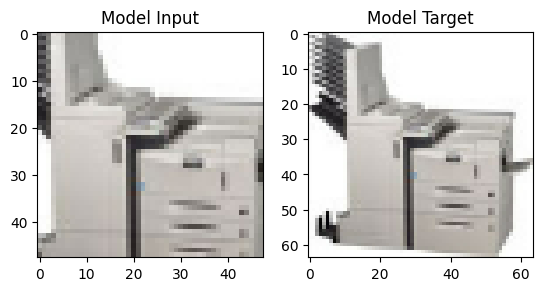

In [17]:
for ex in train_batches.take(1):
  print(type(ex))
  print("Input image sample")
  print(ex[0].shape)
  print("Output image sample for fitting")
  print(ex[1].shape)
  refomatted_image = reformat_image(ex[1][0])
  print("Reformatted image 0 from batch")
  print(refomatted_image.shape)
  print("Label")
  print(ex[2].shape)
  print("\n")

  plt.subplot(1,2,1)
  plt.imshow(ex[0][0])
  plt.title("Model Input")
  plt.subplot(1,2,2)
  plt.imshow(refomatted_image)
  plt.title("Model Target")

#  plt.subplots_adjust(hspace = 0.3)
#  plt.imshow(image_batch[n])
#  color = "blue" if predicted_ids[n] == label_batch[n] else "red"
#  plt.title(predicted_class_names[n].title(), color=color)
#  plt.axis('off')


## Building the Model

I will start with a simple sequential definition to get started.
I plan to create more complicated topogies to reflect the fact that all the details of the input should be included in the output.

Reminder for myself of how to build a model with the functional API


```
inputs = keras.Input(shape=(784,), name="digits")
x = layers.Dense(64, activation="relu", name="dense_1")(inputs)
x = layers.Dense(64, activation="relu", name="dense_2")(x)
outputs = layers.Dense(10, activation="softmax", name="predictions")(x)

model = keras.Model(inputs=inputs, outputs=outputs)
```



More Ideas to include:
spatial dropout: https://www.tensorflow.org/api_docs/python/tf/keras/layers/SpatialDropout2D

Or maybe this is not a good idea for this case.

Obvious to include:
CNN

Could also try https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2DTranspose

Also known as deconvolution.




One very complicated feature to implement would be to get the raw input mapped to the final nodes. I have tried mapping the full input to the full output, but this does add a lot of parameters that aren't needed. Would it be possible to fix those parameters so each original pixel would connect only to the corresponding final pixel? This would not be that efficient, as the program would still do the math for all the zero weights. But that math with the weight*vector computation is relatively simple.

It would probably make more sense to force the outputs to be the original values in that region, but that would be hard to do within the model. For optimal performance, the best thing to do would be to rework the project so only the edge pixels are actually fitted at all.

Another idea: create a layer that 0 pads the input to match the final resolution. Then it may be possible to do convolutional layers all the way, without a final dense layer.
This could be done with this function, though it would have to be implemented inside a layer. Could that be done with a lambda layer?

https://www.tensorflow.org/api_docs/python/tf/image/pad_to_bounding_box

or

https://www.tensorflow.org/api_docs/python/tf/image/resize_with_crop_or_pad

or

https://www.tensorflow.org/api_docs/python/tf/keras/layers/ZeroPadding2D


I have confirmed that with my configuration, it does not matter if the final layer is Conv2D or Conv2DTranspose. The difference, as I understand it, is that I could use Conv2DTranpose to increase the dimension. Doing so may make some sense, but I may want to do several steps of 2D tranpose convolutions then, and would need to keep careful track of how the dimensions increase, so that they end up increasing to just the right amount.



(1, 64, 64, 1)


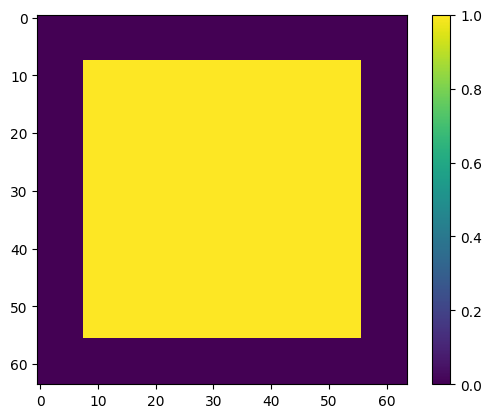

In [26]:
def build_mask():
  tensor = tf.ones((1,SAMPLE_WIDTH,SAMPLE_HEIGHT,1))
  symmetric_padding_distance = int((TOTAL_HEIGHT - SAMPLE_HEIGHT) / 2)
  tensor = tf.keras.layers.ZeroPadding2D(padding=symmetric_padding_distance)(tensor)
  return tensor

tensor_mask = build_mask()
print(tensor_mask.shape)
plt.imshow(tensor_mask[0,:,:,:])
plt.colorbar()

(1, 64, 64, 1)
(1, 64, 64, 3)
(1, 64, 64, 1)


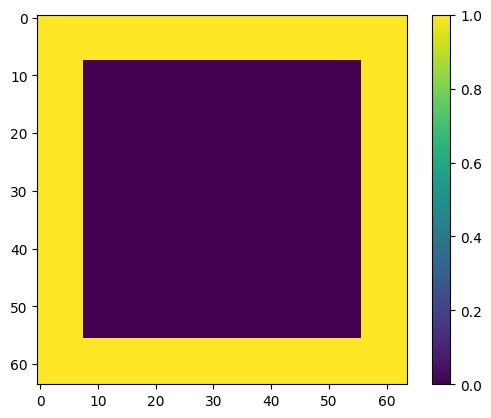

In [25]:
#tensor_boundary_mask = tf.layers.Lambda(lambda x : (x == 0 ? 1 : 0))(tensor_mask)
print(tensor_mask.shape)
print((1,TOTAL_WIDTH,TOTAL_HEIGHT,3))
tensor_boundary_mask = tf.ones((1,TOTAL_WIDTH,TOTAL_HEIGHT,1))
tensor_boundary_mask = tf.subtract(tensor_boundary_mask,tensor_mask)
print(tensor_boundary_mask.shape)
plt.imshow(tensor_boundary_mask[0,:,:,:])
plt.colorbar()

(None, 64, 64, 3)
Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 48, 48, 3)]  0           []                               
                                                                                                  
 zero_padding2d_5 (ZeroPadding2  (None, 64, 64, 3)   0           ['input_4[0][0]']                
 D)                                                                                               
                                                                                                  
 conv2d_11 (Conv2D)             (None, 64, 64, 64)   1792        ['zero_padding2d_5[0][0]']       
                                                                                                  
 conv2d_12 (Conv2D)             (None, 64, 64, 128)  401536      ['conv2d_

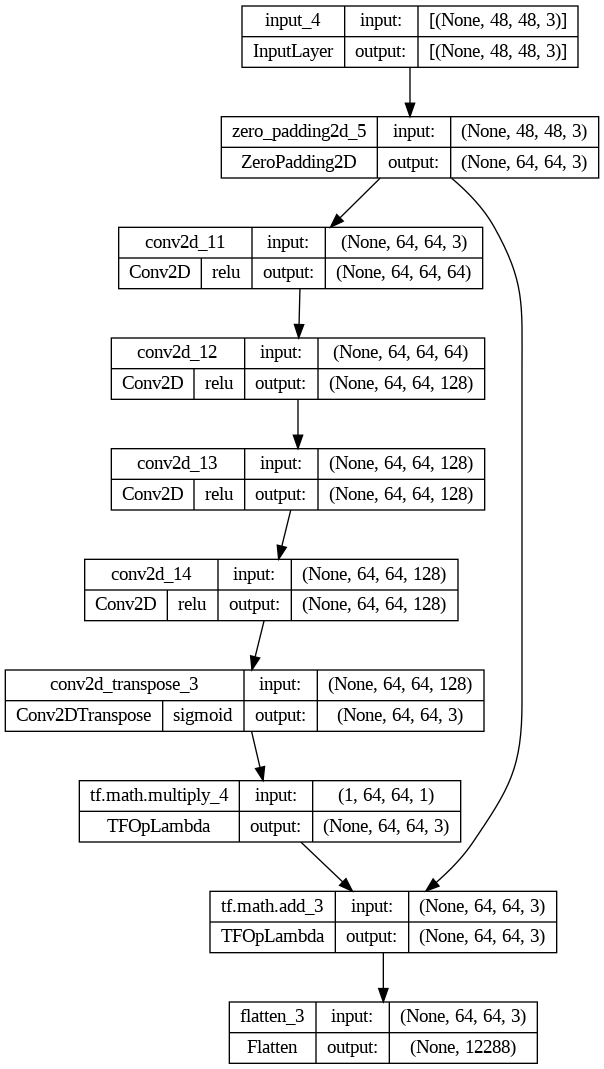

In [30]:
from keras.regularizers import L2

# first version, defined sequentially
#model = tf.keras.Sequential([
#    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(SAMPLE_WIDTH, SAMPLE_HEIGHT, 3)),
#    tf.keras.layers.Dense(2048,activation='relu'),
#    tf.keras.layers.Dense(TOTAL_WIDTH*TOTAL_WIDTH*3, activation='relu')
#])
#tf.keras.backend.clear_session()

model_file_path = "model.keras"
#model_file_path = "drive/MyDrive/DataScience/Extrap/model_17.keras"


# load existing model
#model_version = -1

# shallow network
#model_version = 0

# One CNN
#model_version = 1

# Two CNNs
#model_version = 2

# Three CNNs
#model_version = 3

# Three CNNs with skipping
#model_version = 4

# Three CNNs with skipping and dropout
#model_version = 5

# Attempting to use padding and CNNs to avoid
# dense layers
#model_version = 6

# Pure CNN, with larger sizes.
#model_version = 7

# Pure CNN, with larger sizes and fewer filters
#model_version = 8

# Pure CNN, experimenting
#model_version = 9

# Trying a RGB filter layer and L2 regularization
#model_version = 10


# Pure CNN, with larger sizes.
# Based on model 7, but implementing proper forwarding of the inner sample box
model_version = 11

# Very experimental
#model_version = 12

# second version, defined functionally
def create_model():

  if model_version == -1: # load existing model
    model = tf.keras.models.load_model(model_file_path)
    return model

  inputs = tf.keras.Input(shape=(SAMPLE_WIDTH, SAMPLE_HEIGHT, 3))
  #x = tf.keras.layers.Conv2D(32, (3,3), activation='relu')(inputs)
  #outputs = create_output_layer(x)

  if (model_version == 0):

    flattenned_input = tf.keras.layers.Flatten()(inputs)
    outputs = tf.keras.layers.Dense(TOTAL_HEIGHT*TOTAL_WIDTH*3, activation='sigmoid')(flattenned_input)

  if (model_version == 1):
    x = tf.keras.layers.Conv2D(32, (3,3), activation='relu',input_shape=(SAMPLE_WIDTH, SAMPLE_HEIGHT, 3))(inputs)
    #x = tf.keras.layers.Conv3D(32,(3,3,3),activation='relu')(inputs)
    x = tf.keras.layers.Flatten()(x)
    outputs = tf.keras.layers.Dense(TOTAL_HEIGHT*TOTAL_WIDTH*3, activation='sigmoid')(x)

  if (model_version == 2):
    x = tf.keras.layers.Conv2D(32, (3,3), activation='relu',input_shape=(SAMPLE_WIDTH, SAMPLE_HEIGHT, 3))(inputs)
    x = tf.keras.layers.Conv2D(32, (3,3), activation='relu',input_shape=(SAMPLE_WIDTH, SAMPLE_HEIGHT, 3))(x)
    x = tf.keras.layers.Flatten()(x)
    outputs = tf.keras.layers.Dense(TOTAL_HEIGHT*TOTAL_WIDTH*3, activation='sigmoid')(x)

  if (model_version == 3):
    x = tf.keras.layers.Conv2D(32, (3,3), activation='relu',input_shape=(SAMPLE_WIDTH, SAMPLE_HEIGHT, 3))(inputs)
    x = tf.keras.layers.Conv2D(32, (3,3), activation='relu',input_shape=(SAMPLE_WIDTH, SAMPLE_HEIGHT, 3))(x)
    x = tf.keras.layers.Conv2D(32, (3,3), activation='relu',input_shape=(SAMPLE_WIDTH, SAMPLE_HEIGHT, 3))(x)
    x = tf.keras.layers.Flatten()(x)
    outputs = tf.keras.layers.Dense(TOTAL_HEIGHT*TOTAL_WIDTH*3, activation='sigmoid')(x)

  if (model_version == 4):
    layer1_output = tf.keras.layers.Conv2D(32, (3,3), activation='relu',input_shape=(SAMPLE_WIDTH, SAMPLE_HEIGHT, 3))(inputs)
    layer2_output = tf.keras.layers.Conv2D(32, (3,3), activation='relu',input_shape=(SAMPLE_WIDTH, SAMPLE_HEIGHT, 3))(layer1_output)
    layer3_output = tf.keras.layers.Conv2D(32, (3,3), activation='relu',input_shape=(SAMPLE_WIDTH, SAMPLE_HEIGHT, 3))(layer2_output)

    layer_1_output_flattenned = tf.keras.layers.Flatten()(layer1_output)
    layer_2_output_flattenned = tf.keras.layers.Flatten()(layer2_output)
    layer_3_output_flattenned = tf.keras.layers.Flatten()(layer3_output)

    x = tf.keras.layers.Concatenate(axis=-1)([layer_1_output_flattenned,layer_2_output_flattenned,layer_3_output_flattenned])

    outputs = tf.keras.layers.Dense(TOTAL_HEIGHT*TOTAL_WIDTH*3, activation='sigmoid')(x)

  if (model_version == 5):
    layer1_output = tf.keras.layers.Conv2D(64, (3,3), activation='relu',padding="same",input_shape=(SAMPLE_WIDTH, SAMPLE_HEIGHT, 3))(inputs)
    layer1_output = tf.keras.layers.Dropout(rate = 0.3)(layer1_output)

    layer2_output = tf.keras.layers.Conv2D(64, (5,5), activation='relu',padding="same",input_shape=(SAMPLE_WIDTH, SAMPLE_HEIGHT, 3))(layer1_output)
    layer2_output = tf.keras.layers.Dropout(rate = 0.3)(layer2_output)

    layer3_output = tf.keras.layers.Conv2D(64, (7,7), activation='relu',padding="same",input_shape=(SAMPLE_WIDTH, SAMPLE_HEIGHT, 3))(layer2_output)
    layer3_output = tf.keras.layers.Dropout(rate = 0.3)(layer3_output)

    layer_1_output_flattenned = tf.keras.layers.Flatten()(layer1_output)
    layer_2_output_flattenned = tf.keras.layers.Flatten()(layer2_output)
    layer_3_output_flattenned = tf.keras.layers.Flatten()(layer3_output)

    x = tf.keras.layers.Concatenate(axis=-1)([layer_1_output_flattenned,layer_2_output_flattenned,layer_3_output_flattenned])

    outputs = tf.keras.layers.Dense(TOTAL_HEIGHT*TOTAL_WIDTH*3, activation='sigmoid')(x)


  if (model_version == 6):
    symmetric_padding_distance = int((TOTAL_HEIGHT - SAMPLE_HEIGHT) / 2)
    x = tf.keras.layers.ZeroPadding2D(padding=symmetric_padding_distance)(inputs)
    layer1_output = tf.keras.layers.Conv2D(64,(3,3),activation='relu',padding='same',input_shape=(TOTAL_WIDTH, TOTAL_HEIGHT, 3))(x)

    layer2_output = tf.keras.layers.Conv2D(128,(5,5),activation='relu',padding='same',input_shape=(TOTAL_WIDTH, TOTAL_HEIGHT, 3))(layer1_output)

    layer3_output = tf.keras.layers.Conv2D(128,(7,7),activation='relu',padding='same',input_shape=(TOTAL_WIDTH, TOTAL_HEIGHT, 3))(layer2_output)

    # should be sigmoid if this is the final output
    layer_3_output_deconv = tf.keras.layers.Conv2DTranspose(3,(3,3),activation='sigmoid',padding='same')(layer3_output)

#    layer_3_output_flattenned = tf.keras.layers.Flatten()(layer3_output)
    x = tf.keras.layers.Flatten()(layer_3_output_deconv)
    outputs = x
#    outputs = tf.keras.layers.Dense(TOTAL_HEIGHT*TOTAL_WIDTH*3, activation='sigmoid')(x)
  if (model_version == 7):
    symmetric_padding_distance = int((TOTAL_HEIGHT - SAMPLE_HEIGHT) / 2)
    x = tf.keras.layers.ZeroPadding2D(padding=symmetric_padding_distance)(inputs)

    layer1_output = tf.keras.layers.Conv2D(64,(3,3),activation='relu',padding='same',input_shape=(TOTAL_WIDTH, TOTAL_HEIGHT, 3))(x)
    layer2_output = tf.keras.layers.Conv2D(128,(7,7),activation='relu',padding='same',input_shape=(TOTAL_WIDTH, TOTAL_HEIGHT, 3))(layer1_output)
    layer3_output = tf.keras.layers.Conv2D(128,(13,13),activation='relu',padding='same',input_shape=(TOTAL_WIDTH, TOTAL_HEIGHT, 3))(layer2_output)

    # should be sigmoid if this is the final output
    layer_3_output_deconv = tf.keras.layers.Conv2DTranspose(3,(13,13),activation='sigmoid',padding='same')(layer3_output)

    x = tf.keras.layers.Flatten()(layer_3_output_deconv)
    outputs = x


  if (model_version == 8):
    symmetric_padding_distance = int((TOTAL_HEIGHT - SAMPLE_HEIGHT) / 2)
    x = tf.keras.layers.ZeroPadding2D(padding=symmetric_padding_distance)(inputs)

    layer1_output = tf.keras.layers.Conv2D(120,(5,5),activation='relu',padding='same',input_shape=(TOTAL_WIDTH, TOTAL_HEIGHT, 3))(x)
    layer2_output = tf.keras.layers.Conv2D(30,(35,35),activation='relu',padding='same',input_shape=(TOTAL_WIDTH, TOTAL_HEIGHT, 3))(layer1_output)
    #layer3_output = tf.keras.layers.Conv2D(36,(15,15),activation='relu',padding='same',input_shape=(TOTAL_WIDTH, TOTAL_HEIGHT, 3))(layer2_output)
    #layer4_output = tf.keras.layers.Conv2D(36,(19,19),activation='relu',padding='same',input_shape=(TOTAL_WIDTH, TOTAL_HEIGHT, 3))(layer3_output)

    # should be sigmoid if this is the final output
    final_output = tf.keras.layers.Conv2DTranspose(3,(45,45),activation='sigmoid',padding='same')(layer2_output)

    x = tf.keras.layers.Flatten()(final_output)
    outputs = x

  if (model_version == 9):
    symmetric_padding_distance = int((TOTAL_HEIGHT - SAMPLE_HEIGHT) / 2)
    x = tf.keras.layers.ZeroPadding2D(padding=symmetric_padding_distance)(inputs)

    layer1_output = tf.keras.layers.Conv2D(36,(5,5),name='layer_1',activation='relu',padding='same',input_shape=(TOTAL_WIDTH, TOTAL_HEIGHT, 3))(x)
    layer2_output = tf.keras.layers.Conv2D(36,(10,10),name='layer_2',activation='relu',padding='same',input_shape=(TOTAL_WIDTH, TOTAL_HEIGHT, 3))(layer1_output)
    #layer3_output = tf.keras.layers.Conv2D(36,(15,15),activation='relu',padding='same',input_shape=(TOTAL_WIDTH, TOTAL_HEIGHT, 3))(layer2_output)
    #layer4_output = tf.keras.layers.Conv2D(36,(19,19),activation='relu',padding='same',input_shape=(TOTAL_WIDTH, TOTAL_HEIGHT, 3))(layer3_output)

    # should be sigmoid if this is the final output
    #final_output = tf.keras.layers.Conv2DTranspose(3,(9,9),activation='sigmoid',padding='same')(layer2_output)
    # Checking to see if conv2D vs conv2DTranspose matters in this case
    # I suspect it does not, base don the padding settings
    final_output = tf.keras.layers.Conv2D(3,(9,9),name='layer_final',activation='sigmoid',padding='same')(layer2_output)


    x = tf.keras.layers.Flatten()(final_output)
    outputs = x


  if (model_version == 10):
    symmetric_padding_distance = int((TOTAL_HEIGHT - SAMPLE_HEIGHT) / 2)
#    x = tf.keras.layers.ZeroPadding3D(padding=(symmetric_padding_distance,symmetric_padding_distance,0))(inputs)
    x = tf.keras.layers.ZeroPadding2D(padding=symmetric_padding_distance)(inputs)

    # Layer that should just filter the the R,G,B layers
    # To setup and fix the initial parameters of the RGB filter layer, some ideas I have are to use this initializer:
    #tf.keras.initializers.Orthogonal(gain=1.0, seed=None)
    layer0_output = tf.keras.layers.Conv2D(3,(1,1),kernel_regularizer=L2(0.001),activation='relu',padding='same',input_shape=(TOTAL_WIDTH, TOTAL_HEIGHT, 3))(x)


#    layer1_output = tf.keras.layers.Conv3D(36,(3,3,1),activation='relu',padding='same',input_shape=(TOTAL_WIDTH, TOTAL_HEIGHT, 3))(x)
#    layer2_output = tf.keras.layers.Conv3D(36,(5,5,1),activation='relu',padding='same',input_shape=(TOTAL_WIDTH, TOTAL_HEIGHT, 3))(layer1_output)

    layer1_output = tf.keras.layers.Conv2D(36,(3,3),kernel_regularizer=L2(0.001),activation='relu',padding='same',input_shape=(TOTAL_WIDTH, TOTAL_HEIGHT, 3))(layer0_output)
    layer2_output = tf.keras.layers.Conv2D(36,(5,5),kernel_regularizer=L2(0.001),activation='relu',padding='same',input_shape=(TOTAL_WIDTH, TOTAL_HEIGHT, 3))(layer1_output)

    #layer3_output = tf.keras.layers.Conv2D(36,(15,15),activation='relu',padding='same',input_shape=(TOTAL_WIDTH, TOTAL_HEIGHT, 3))(layer2_output)
    #layer4_output = tf.keras.layers.Conv2D(36,(19,19),activation='relu',padding='same',input_shape=(TOTAL_WIDTH, TOTAL_HEIGHT, 3))(layer3_output)

    # should be sigmoid if this is the final output
    #final_output = tf.keras.layers.Conv2DTranspose(3,(9,9),activation='sigmoid',padding='same')(layer2_output)
    # Checking to see if conv2D vs conv2DTranspose matters in this case
    # I suspect it does not, base don the padding settings
    #final_output = tf.keras.layers.Conv3D(3,(9,9),activation='sigmoid',padding='same')(layer2_output)
    final_output = tf.keras.layers.Conv2D(3,(9,9),kernel_regularizer=L2(0.001),activation='sigmoid',padding='same')(layer2_output)



    x = tf.keras.layers.Flatten()(final_output)
    outputs = x


  if (model_version == 11):
    symmetric_padding_distance = int((TOTAL_HEIGHT - SAMPLE_HEIGHT) / 2)
    padded_input = tf.keras.layers.ZeroPadding2D(padding=symmetric_padding_distance)(inputs)

    layer1_output = tf.keras.layers.Conv2D(64,(3,3),activation='relu',padding='same',input_shape=(TOTAL_WIDTH, TOTAL_HEIGHT, 3))(padded_input)
    layer2_output = tf.keras.layers.Conv2D(128,(7,7),activation='relu',padding='same',input_shape=(TOTAL_WIDTH, TOTAL_HEIGHT, 3))(layer1_output)
    layer3_output = tf.keras.layers.Conv2D(128,(13,13),activation='relu',padding='same',input_shape=(TOTAL_WIDTH, TOTAL_HEIGHT, 3))(layer2_output)
    layer4_output = tf.keras.layers.Conv2D(128,(13,13),activation='relu',padding='same',input_shape=(TOTAL_WIDTH, TOTAL_HEIGHT, 3))(layer3_output)

    # should be sigmoid if this is the final output
    layer_3_output_deconv = tf.keras.layers.Conv2DTranspose(3,(13,13),activation='sigmoid',padding='same')(layer4_output)

    # apply up scaling to make make 1.0 reachable
    color_scale_factor = 1.2
    active_output = tf.multiply(layer_3_output_deconv,color_scale_factor)

    # tensor_mask, tensor_boundary_mask
    filtered_output = tf.multiply(tensor_boundary_mask,layer_3_output_deconv)
    filtered_output = tf.add(filtered_output,padded_input)
    print(filtered_output.shape)

    x = tf.keras.layers.Flatten()(filtered_output)
    outputs = x

  if (model_version == 12):
    # Trying UNet like model
    symmetric_padding_distance = int((TOTAL_HEIGHT - SAMPLE_HEIGHT) / 2)
    padded_input = tf.keras.layers.ZeroPadding2D(padding=symmetric_padding_distance)(inputs)



    # Downward section
    layer1_output = tf.keras.layers.Conv2D(64,(3,3),activation='relu',padding='same',input_shape=(TOTAL_WIDTH, TOTAL_HEIGHT, 3))(padded_input)
    layer2_output = tf.keras.layers.Conv2D(64,(7,7),activation='relu',padding='same',input_shape=(TOTAL_WIDTH, TOTAL_HEIGHT, 3))(layer1_output)
    layer3_output = tf.keras.layers.Conv2D(64,(13,13),activation='relu',padding='same',input_shape=(TOTAL_WIDTH, TOTAL_HEIGHT, 3))(layer2_output)

    #print(f"layer3_output size = {layer3_output.shape}")

    # Deep section
    #pooled_1 = tf.keras.layers.MaxPooling2D(pool_size=(7,7))(layer3_output)

    #pooled_size = pooled_1.shape[1]*pooled_1.shape[2]*pooled_1.shape[3]

    #print(pooled_1.shape)

    #dense_layer_1 = tf.keras.layers.Dense(pooled_size,activation='relu')(pooled_1)

        #x = tf.keras.layers.Flatten()(x)
    #outputs = tf.keras.layers.Dense(TOTAL_HEIGHT*TOTAL_WIDTH*3, activation='sigmoid')(x)



    input_to_outgoing_layers = layer3_output

    #print(f"Input to outgoing layers has shape {input_to_outgoing_layers.shape}")

    # experiment with combining initial image and new features
    # axis = 3 should be the filter axis
    #merge_output = tf.keras.layers.Concatenate(axis=3)([outgoing_layer_1_output_deconv,padded_input])
    # final filter layer
    #merge_output = tf.keras.layers.Conv2DTranspose(3,(1,1),activation='sigmoid',padding='same')(merge_output)

    # should be sigmoid if this is the final output



    # Upward Section

    # Reversing the layers to see what happens
    outgoing_layer_3_output_deconv = tf.keras.layers.Conv2DTranspose(64,(13,13),activation='relu',padding='same')(input_to_outgoing_layers)
    outgoing_layer_2_output_deconv = tf.keras.layers.Conv2DTranspose(32,(7,7),activation='relu',padding='same')(outgoing_layer_3_output_deconv)
    outgoing_layer_1_output_deconv = tf.keras.layers.Conv2DTranspose(32,(3,3),activation='relu',padding='same')(outgoing_layer_2_output_deconv)

    merge_output = tf.keras.layers.Concatenate(axis=3)([outgoing_layer_1_output_deconv,padded_input])

    x = tf.keras.layers.Conv2DTranspose(3,(3,3),activation='relu',padding='same')(merge_output)

    x = tf.keras.layers.Flatten()(x)
    outputs = x

  #x = tf.keras.layers.Dense(TOTAL_HEIGHT*TOTAL_WIDTH*3, activation='relu')(flattenned_input)

  ##x = tf.keras.layers.Dense(8*TOTAL_HEIGHT*TOTAL_WIDTH*3, activation='relu')(x)
  ##x = tf.keras.layers.Dropout(rate=0.5)(x)
  ##x = tf.keras.layers.Dense(TOTAL_HEIGHT*TOTAL_WIDTH*3, activation='relu')(x)

  # concatenate the raw input and this
  #x = tf.keras.layers.Concatenate(axis=-1)([flattenned_input, x])

  #outputs = tf.keras.layers.Dense(TOTAL_HEIGHT*TOTAL_WIDTH*3, activation='relu')(x)

  model = tf.keras.Model(inputs=inputs, outputs=outputs)
  return model



model = create_model()
model.compile(
    optimizer='adam',
    loss='mean_squared_error',
    metrics=['mean_squared_error'],
    weighted_metrics=[]
)


    #loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    #metrics=['accuracy']
#)

# Summarize Model
model.summary()
tf.keras.utils.plot_model(model, "model_outline.png", show_shapes=True,show_layer_activations=True)

## Training the Model

This seems run fastest on the V100 High-RAM


What is the best way to train the model?
Is it easy to set it up to train with the (256,256,3) target? Do I have to flatten either the output or the input?



Epoch 1/5
800/800 [==============================] - 3097s 4s/step - loss: 9.9551 - mean_squared_error: 0.0187 - val_loss: 9.4963 - val_mean_squared_error: 0.0176
Epoch 2/5
800/800 [==============================] - 2893s 4s/step - loss: 8.7089 - mean_squared_error: 0.0164 - val_loss: 9.3903 - val_mean_squared_error: 0.0174
Epoch 3/5
800/800 [==============================] - 2890s 4s/step - loss: 8.5311 - mean_squared_error: 0.0160 - val_loss: 8.9700 - val_mean_squared_error: 0.0166
Epoch 4/5
800/800 [==============================] - 2770s 3s/step - loss: 8.4059 - mean_squared_error: 0.0158 - val_loss: 8.8875 - val_mean_squared_error: 0.0164
Epoch 5/5
800/800 [==============================] - 2842s 4s/step - loss: 8.2853 - mean_squared_error: 0.0156 - val_loss: 8.7854 - val_mean_squared_error: 0.0162


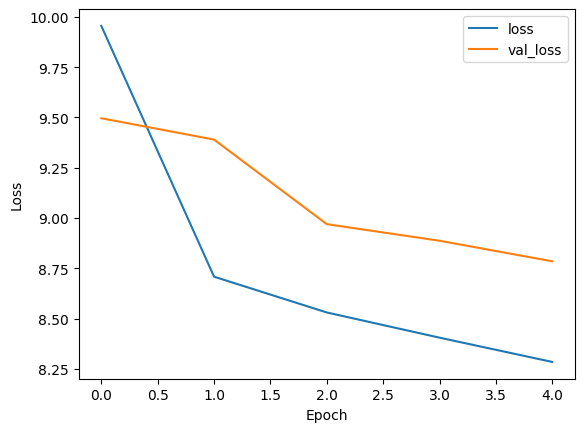

In [31]:
EPOCHS = 5

if model_version != -1:
  history = model.fit(train_batches,epochs=EPOCHS,validation_data=validation_batches)


  # Save the model
  model.save("model.keras")
  # model = keras.models.load_model('path/to/location.keras')
  print(history)

  #plt.plot(history.history['mean_squared_error'], label='mean_squared_error')
  #plt.plot(history.history['val_mean_squared_error'], label='val_mean_squared_error')
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()
  plt.savefig('fit_history.png')

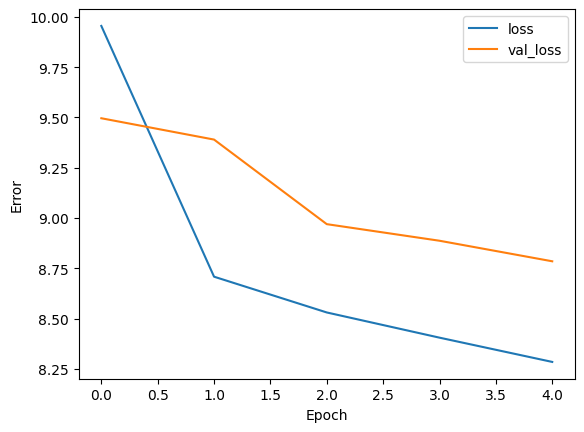

In [32]:

if model_version != -1:
  print(history)

  #plt.plot(history.history['mean_squared_error'], label='mean_squared_error')
  #plt.plot(history.history['val_mean_squared_error'], label='val_mean_squared_error')
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.xlabel('Epoch')
  plt.ylabel('Error')
  plt.legend()
  plt.savefig('fit_history.png')

## Checking some results

I would like to check some results with example images from the test dataset first.
Then, download or upload images from outside of the entire data set and see what the code does.

Some code examples for loading and saving images with PIL


```
from PIL import Image  # Import Image class from library.


image = Image.open("example.jpg")  # Load image.
cropped_image = image.crop((100, 100, 250, 250))  # Crop the image.
cropped_image.save("example_cropped.jpg")  # Save the image.
```

For plotting images in the notebook:
https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.imshow.html

Note that imshow already allows the usage of float (0-1) values for the RGB.



Example 0:
Sample Image: (10, 48, 48, 3)
Image: (10, 12288)
Label: (10,)
tf.Tensor([859 446 656 623 835 549 654 509 349  20], shape=(10,), dtype=int64)
1/1 [==============================] - 1s 594ms/step
tf.Tensor(
[[[0.4784997  0.46507403 0.4164991 ]
  [0.48776668 0.47326362 0.42155638]
  [0.49561372 0.48150095 0.43075714]
  ...
  [0.5970704  0.56075597 0.47982788]
  [0.5917575  0.56019163 0.47980046]
  [0.57872593 0.5498735  0.47151288]]

 [[0.4754255  0.46019852 0.40811437]
  [0.4825556  0.4651529  0.41177407]
  [0.4890025  0.47186357 0.41837615]
  ...
  [0.6127226  0.57166046 0.48306015]
  [0.6089632  0.5703001  0.484615  ]
  [0.5973067  0.5575785  0.47555563]]

 [[0.47452295 0.458649   0.40525568]
  [0.48095128 0.46252054 0.40629762]
  [0.48430303 0.4663454  0.41019732]
  ...
  [0.6168656  0.5752575  0.48372445]
  [0.6150798  0.57206655 0.48471192]
  [0.60340613 0.5606808  0.475824  ]]

 ...

 [[0.65168166 0.53836083 0.4083601 ]
  [0.6787223  0.5545581  0.40738186]
  [0.69996285 

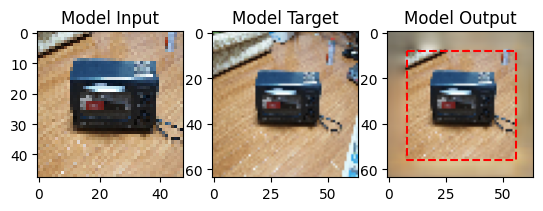

In [33]:
# Plot some examples from the validation set
# use validation_batches

enable_manual_rg_cutoff = False

def plot_image(image):

  plt.imshow(image)

def plot_overlay(ax):
  """
  Plot an overlay showing the region that was used for fitting.
  """
  x_values = [(TOTAL_WIDTH-SAMPLE_WIDTH)*0.5,  (TOTAL_WIDTH+SAMPLE_WIDTH)*0.5,
              (TOTAL_WIDTH+SAMPLE_WIDTH)*0.5,  (TOTAL_WIDTH-SAMPLE_WIDTH)*0.5,
              (TOTAL_WIDTH-SAMPLE_WIDTH)*0.5]
  y_values = [(TOTAL_HEIGHT-SAMPLE_HEIGHT)*0.5,(TOTAL_HEIGHT-SAMPLE_HEIGHT)*0.5,
              (TOTAL_HEIGHT+SAMPLE_HEIGHT)*0.5,(TOTAL_HEIGHT+SAMPLE_HEIGHT)*0.5,
              (TOTAL_HEIGHT-SAMPLE_HEIGHT)*0.5]
  ax.plot(x_values,y_values,color='red',linestyle='--')

enable_overlay = True


for i,ex in enumerate(validation_batches.take(1)):
  sample_image, image, label = ex

  print(f"Example {i}:")
  print(f"Sample Image: {sample_image.shape}")
  print(f"Image: {image.shape}")
  print(f"Label: {label.shape}")

  print(label)

  # Need reversal of flatenning to plot the sample image

  local_batch_size = sample_image.shape[0]

  #for j in range(local_batch_size):
  # plot_image(sample_image[j])

  target_images = list(map(reformat_image,image))
  predicted_images = list(map(reformat_image,model.predict(sample_image)))


  ex_image_index = 0
  print(predicted_images[ex_image_index])

  plt.subplot(1,3,1)
  plot_image(sample_image[ex_image_index])
  plt.title("Model Input")

  plt.subplot(1,3,2)
  plot_image(target_images[ex_image_index])
  plt.title("Model Target")

  ax = plt.subplot(1,3,3)
  plot_image(predicted_images[ex_image_index])
  if (enable_overlay):
    plot_overlay(ax)
  plt.title("Model Output")



  plt.savefig(f"results_example_{i}_single.png")

Example 0:
Sample Image: (10, 48, 48, 3)
Image: (10, 12288)
Label: (10,)
tf.Tensor([859 446 656 623 835 549 654 509 349  20], shape=(10,), dtype=int64)
1/1 [==============================] - 1s 517ms/step
Example 1:
Sample Image: (10, 48, 48, 3)
Image: (10, 12288)
Label: (10,)
tf.Tensor([228 349 364 772 556 223   9 511 347 464], shape=(10,), dtype=int64)
1/1 [==============================] - 1s 529ms/step
Example 2:
Sample Image: (10, 48, 48, 3)
Image: (10, 12288)
Label: (10,)
tf.Tensor([252 757 273 836 441  82 641 107 531  14], shape=(10,), dtype=int64)
1/1 [==============================] - 1s 514ms/step


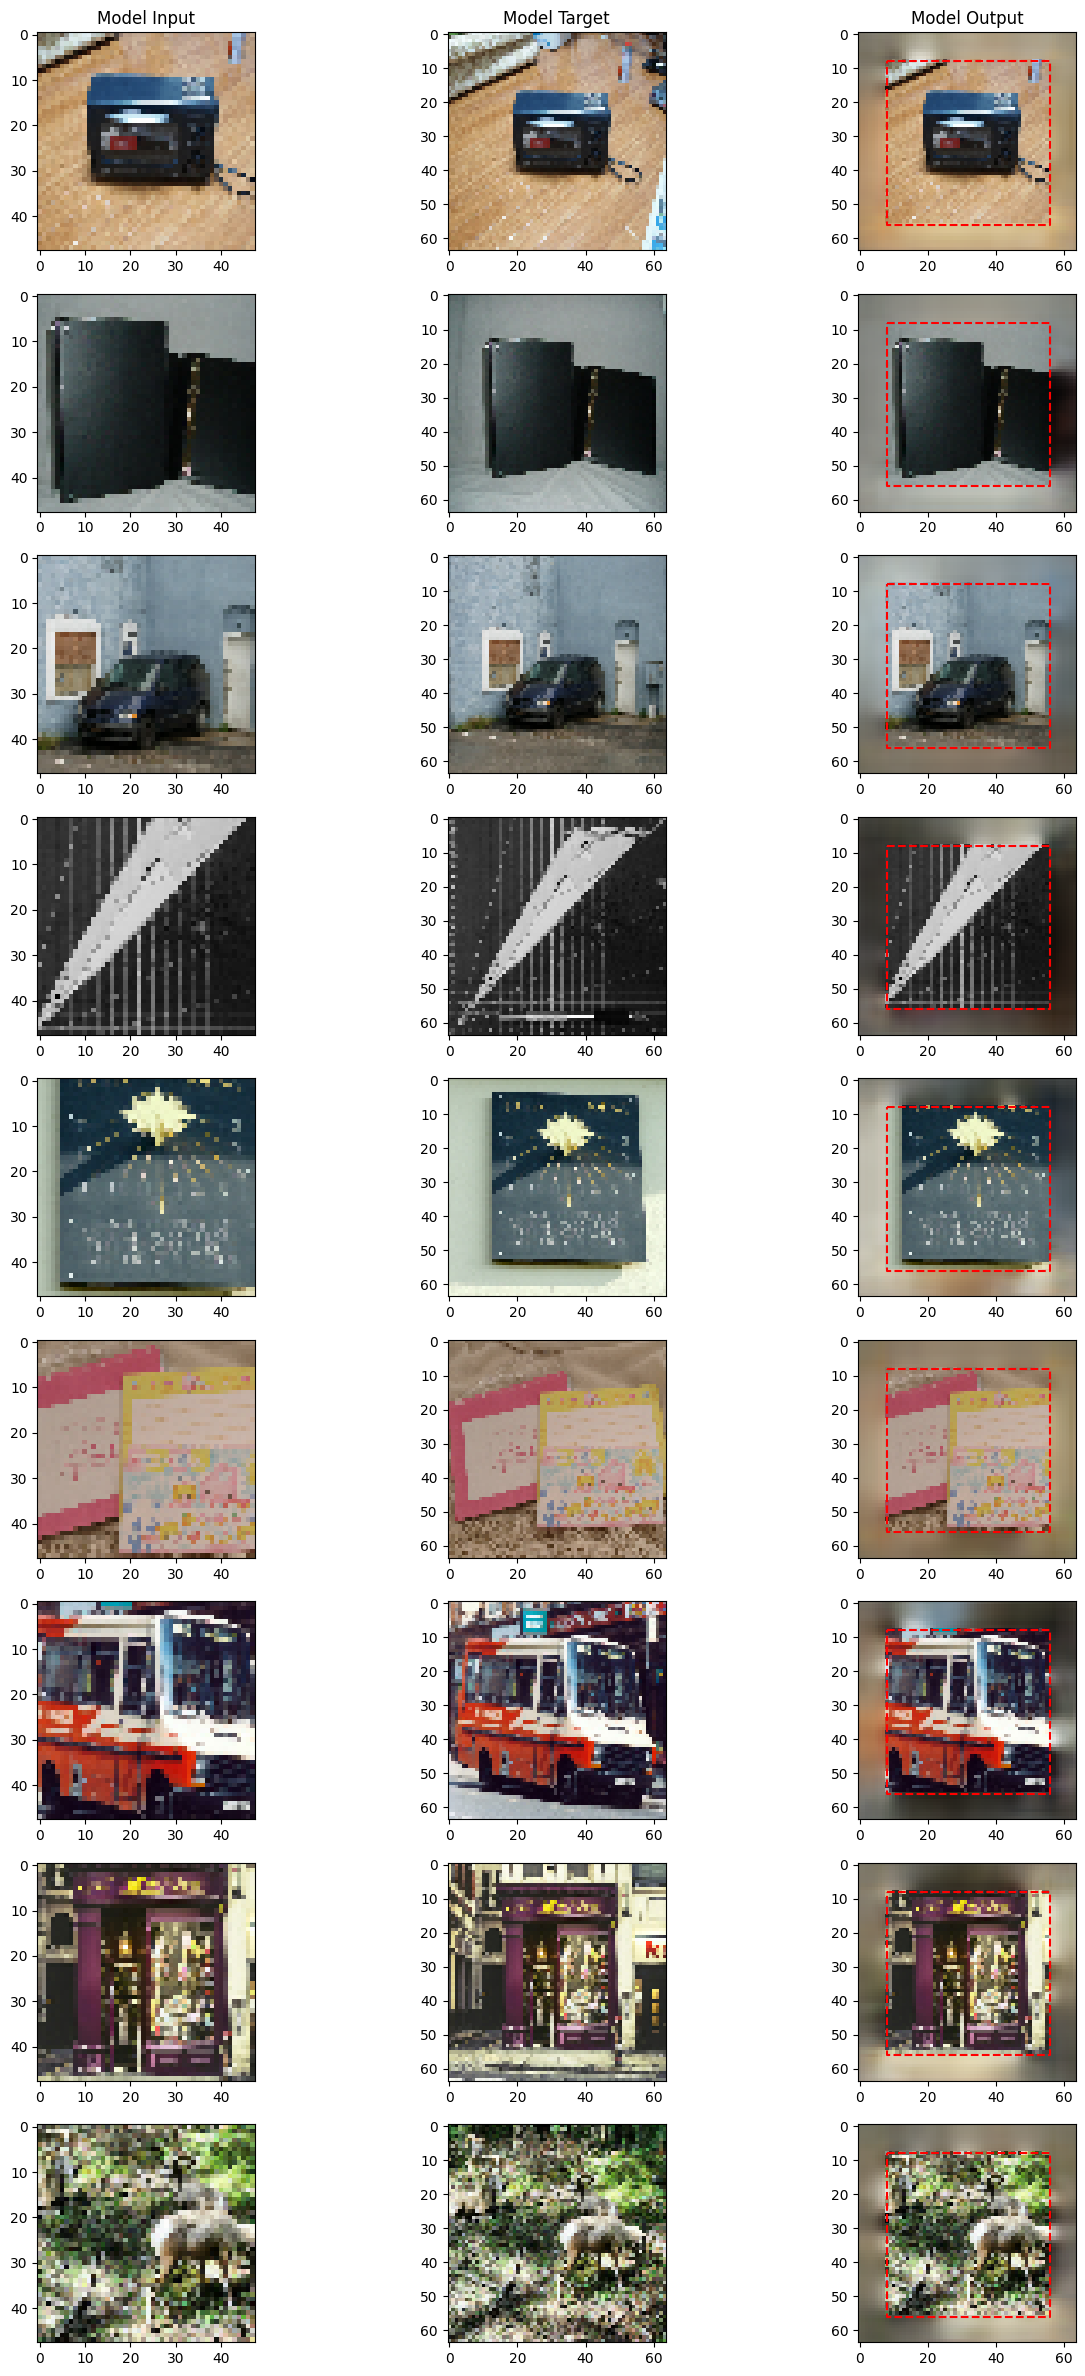

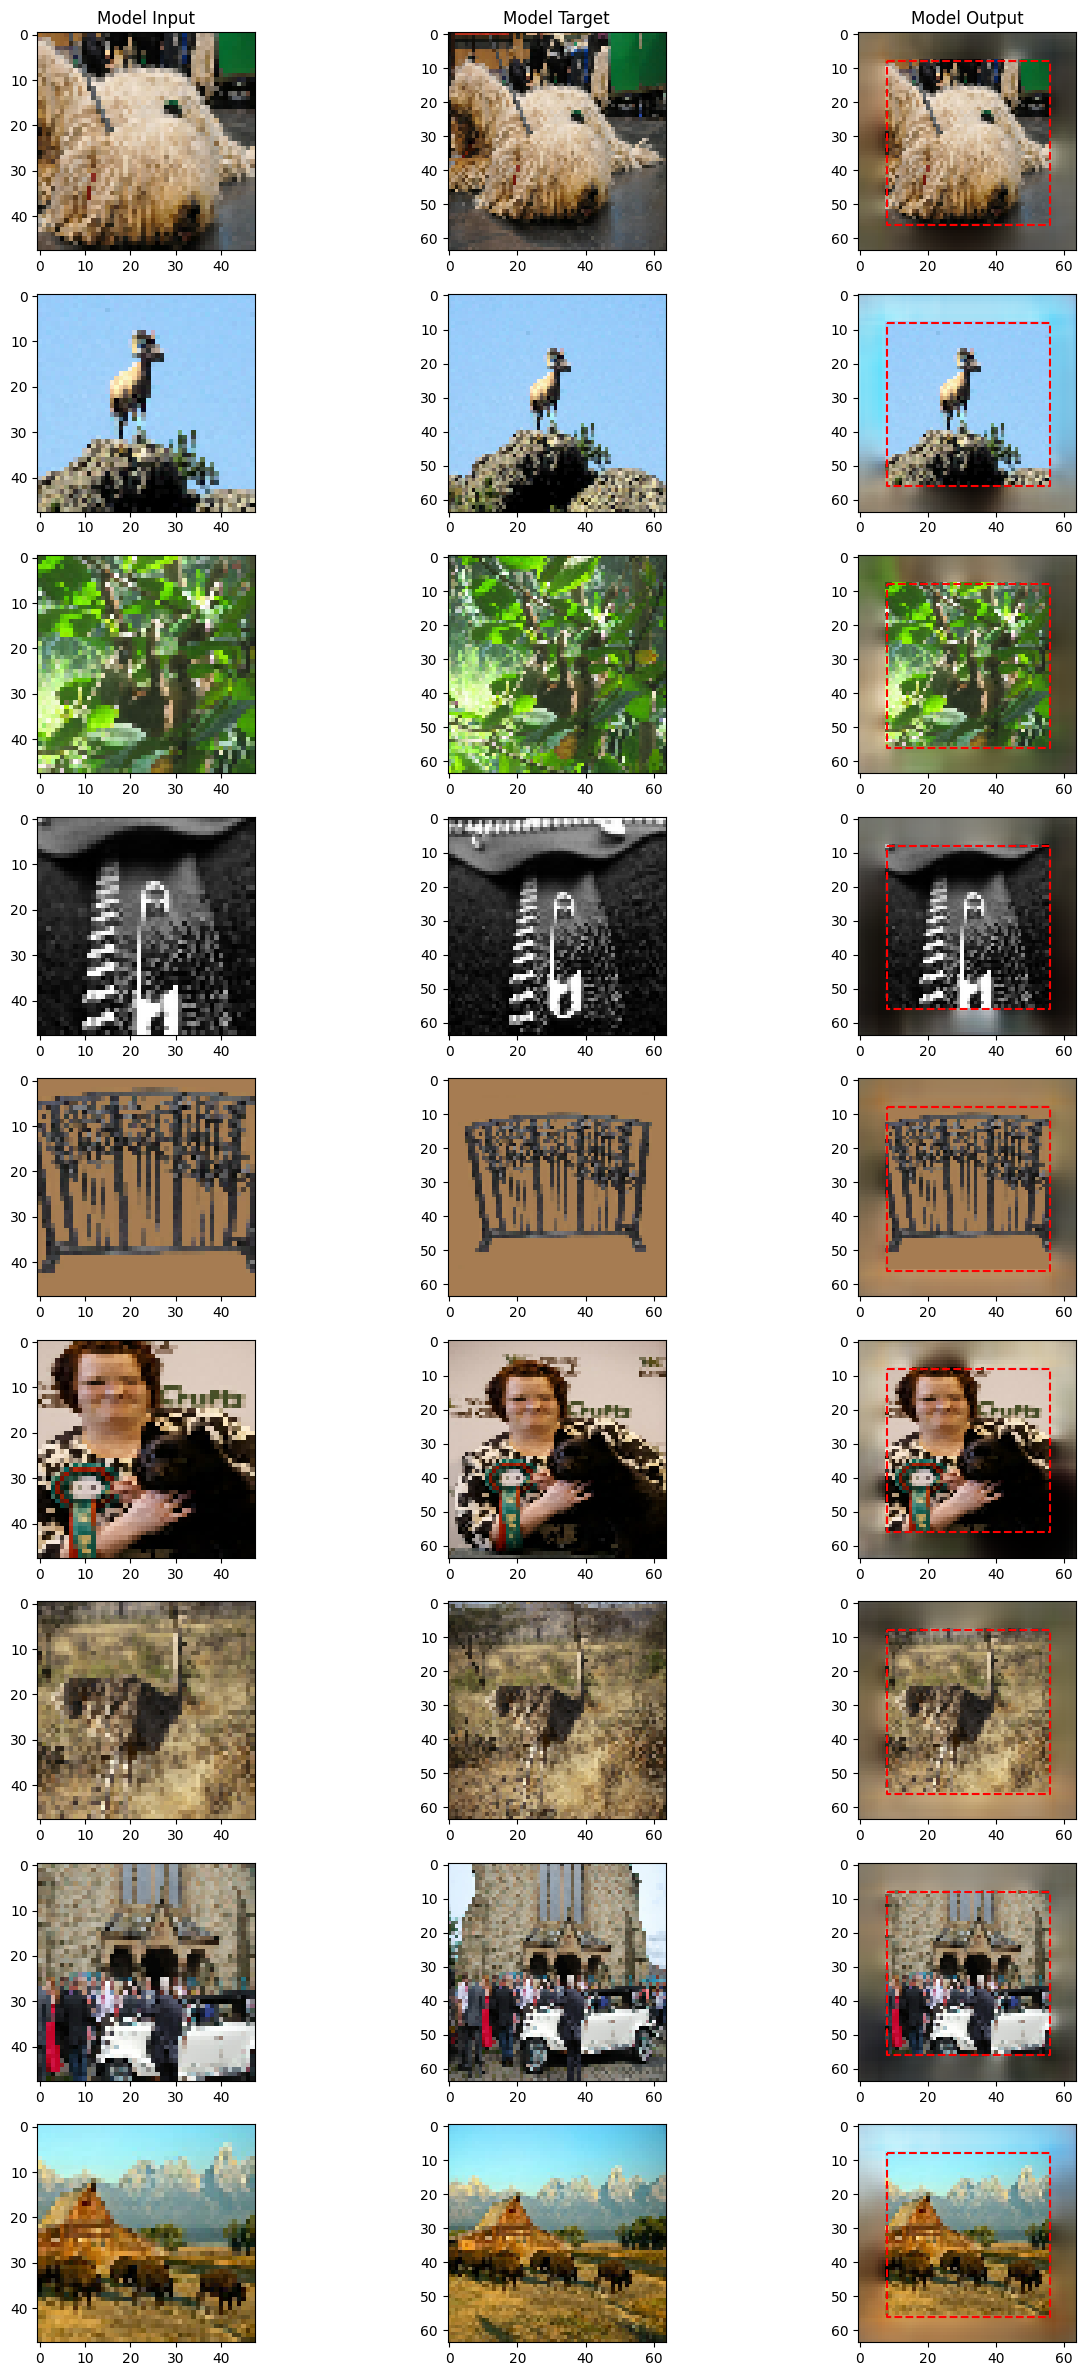

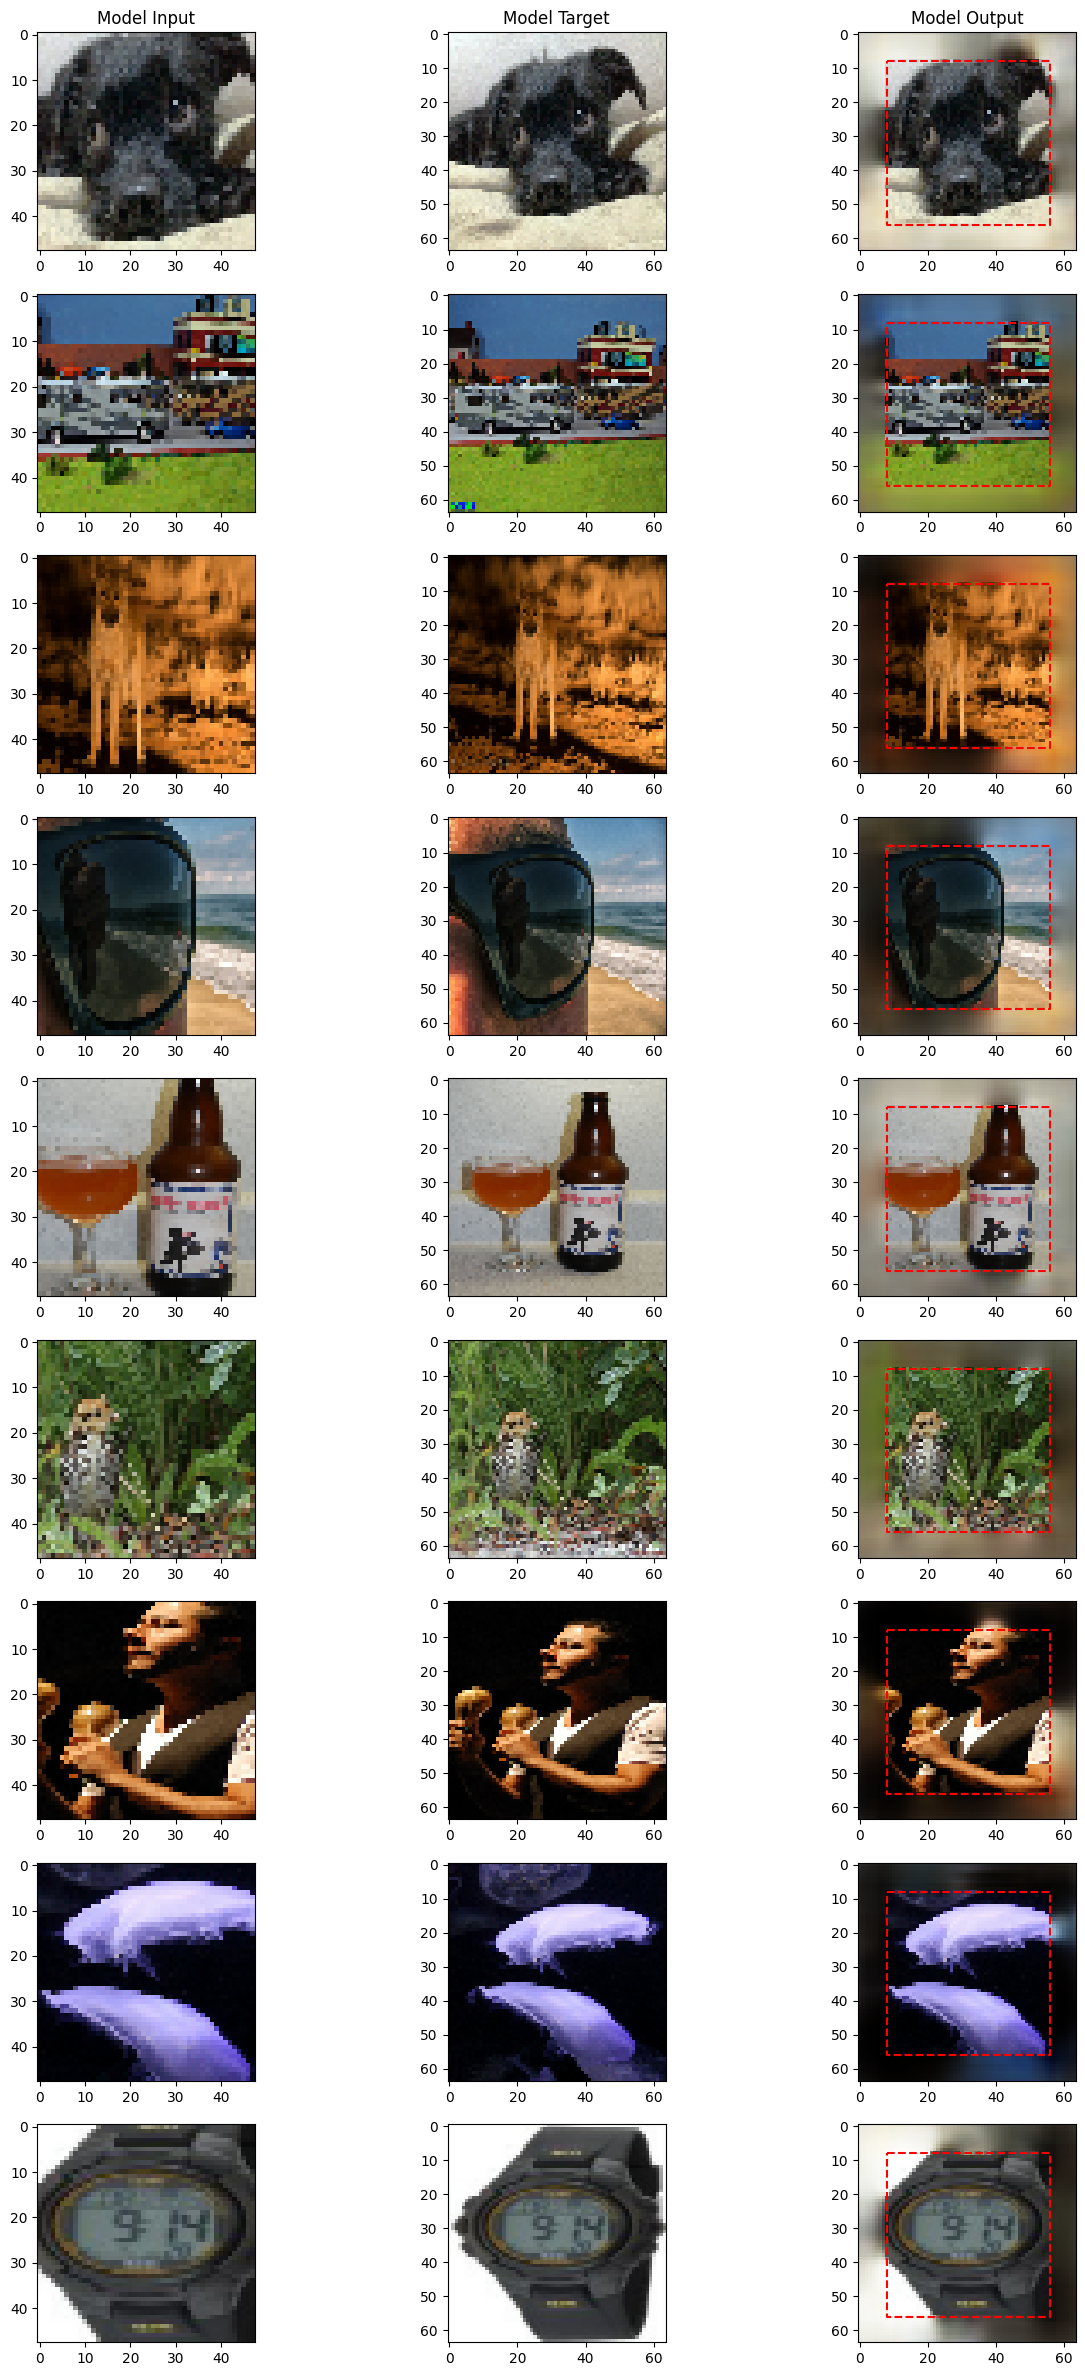

In [34]:


for i,ex in enumerate(validation_batches.take(3)):
  sample_image, image, label = ex

  print(f"Example {i}:")
  print(f"Sample Image: {sample_image.shape}")
  print(f"Image: {image.shape}")
  print(f"Label: {label.shape}")

  print(label)

  # Need reversal of flatenning to plot the sample image

  local_batch_size = sample_image.shape[0]

  #for j in range(local_batch_size):
  # plot_image(sample_image[j])

  target_images = list(map(reformat_image,image))
  predicted_images = list(map(reformat_image,model.predict(sample_image)))

  ex_image_index = 0
  n_images_to_show = 9
  n_images_to_show = min(n_images_to_show,local_batch_size)

  fig, axs = plt.subplots(n_images_to_show, 3,figsize=(15,30))
  for j in range(n_images_to_show):
    #plt.subplots_adjust(hspace = 0.3)

    axs[j,0].imshow(sample_image[j])
    if (j==0):
      axs[j,0].set_title("Model Input")

    axs[j,1].imshow(target_images[j])
    if (j==0):
      axs[j,1].set_title("Model Target")

    axs[j,2].imshow(predicted_images[j])
    if (j==0):
      axs[j,2].set_title("Model Output")
    if (enable_overlay):
      plot_overlay(ax=axs[j,2])
  plt.savefig(f"results_example_{i}.png")

Example 0:
Sample Image: (10, 48, 48, 3)
Image: (10, 12288)
Label: (10,)
tf.Tensor([742 636 217 946 421 353 710 572 429 115], shape=(10,), dtype=int64)
1/1 [==============================] - 1s 522ms/step


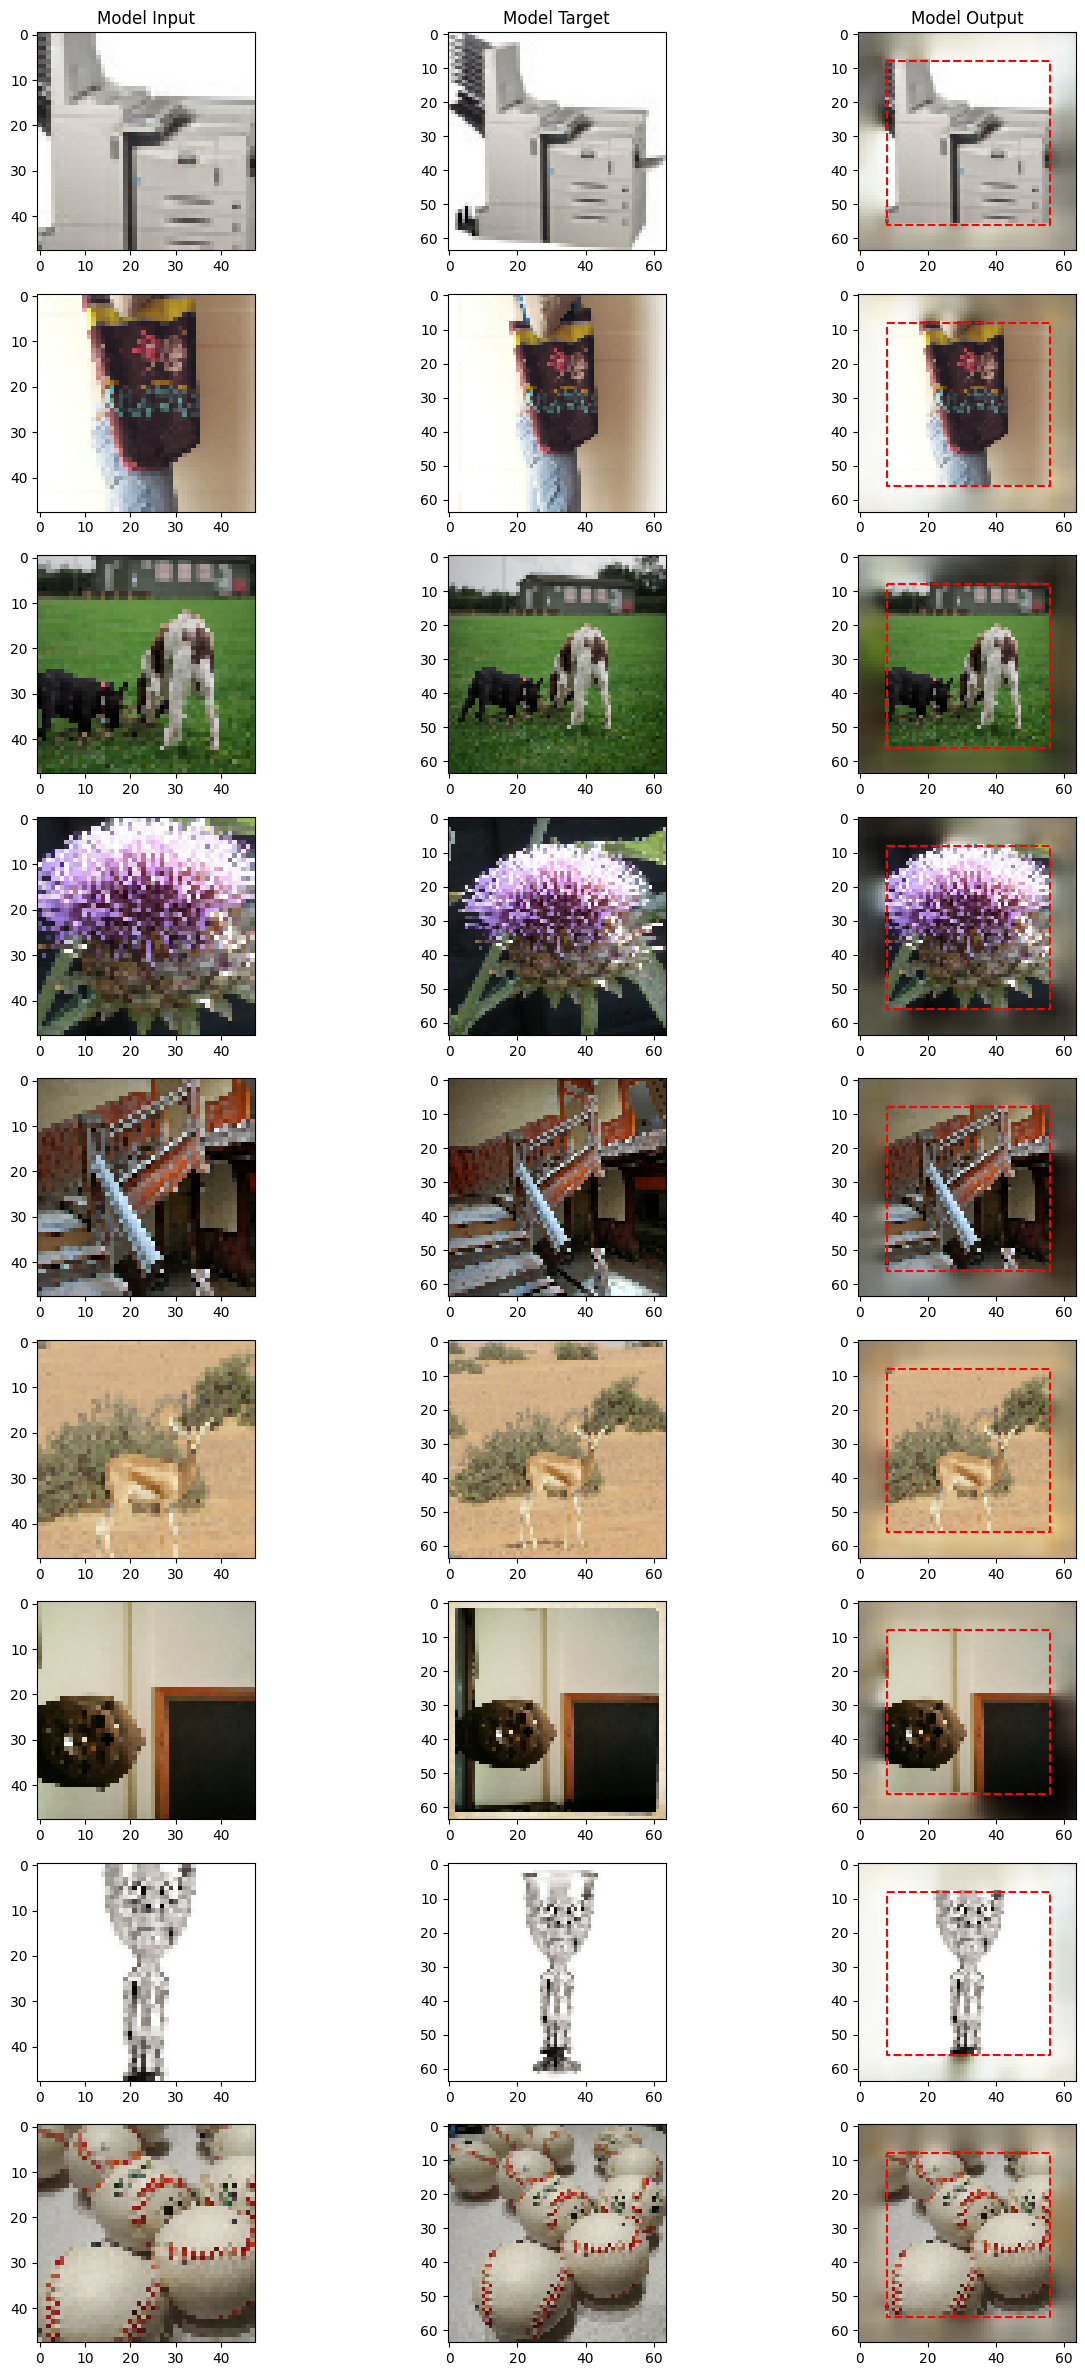

In [35]:
# Check how it did in the training data


for i,ex in enumerate(train_batches.take(1)):
  sample_image, image, label = ex

  print(f"Example {i}:")
  print(f"Sample Image: {sample_image.shape}")
  print(f"Image: {image.shape}")
  print(f"Label: {label.shape}")

  print(label)

  # Need reversal of flatenning to plot the sample image

  local_batch_size = sample_image.shape[0]

  target_images = list(map(reformat_image,image))
  predicted_images = list(map(reformat_image,model.predict(sample_image)))

  ex_image_index = 0
  n_images_to_show = 9
  n_images_to_show = min(n_images_to_show,local_batch_size)

  fig, axs = plt.subplots(n_images_to_show, 3,figsize=(15,30))
  for j in range(n_images_to_show):
    #plt.subplots_adjust(hspace = 0.3)

    axs[j,0].imshow(sample_image[j])
    if (j==0):
      axs[j,0].set_title("Model Input")

    axs[j,1].imshow(target_images[j])
    if (j==0):
      axs[j,1].set_title("Model Target")

    axs[j,2].imshow(predicted_images[j])
    if (j==0):
      axs[j,2].set_title("Model Output")
    if (enable_overlay):
      plot_overlay(ax=axs[j,2])
  plt.savefig(f"results_training_example_{i}.png")

In [36]:
register_heif_opener()

# Trying out on new images


In [37]:
from PIL import Image

directory_of_images_to_use = "drive/MyDrive/DataScience/Extrap/ImagesToUse"

images_list = os.listdir(directory_of_images_to_use)

print(images_list)

# image = Image.open('image.heic')

['IMG_7107.HEIC', 'IMG_7099.HEIC', 'IMG_7096.HEIC', 'IMG_7095.HEIC', 'IMG_7104.HEIC', 'IMG_7073.HEIC']


(1, 48, 48, 3)
1/1 [==============================] - 0s 89ms/step
(1, 48, 48, 3)
1/1 [==============================] - 0s 86ms/step
(1, 48, 48, 3)
1/1 [==============================] - 0s 85ms/step
(1, 48, 48, 3)
1/1 [==============================] - 0s 86ms/step
(1, 48, 48, 3)
1/1 [==============================] - 0s 85ms/step
(1, 48, 48, 3)
1/1 [==============================] - 0s 84ms/step


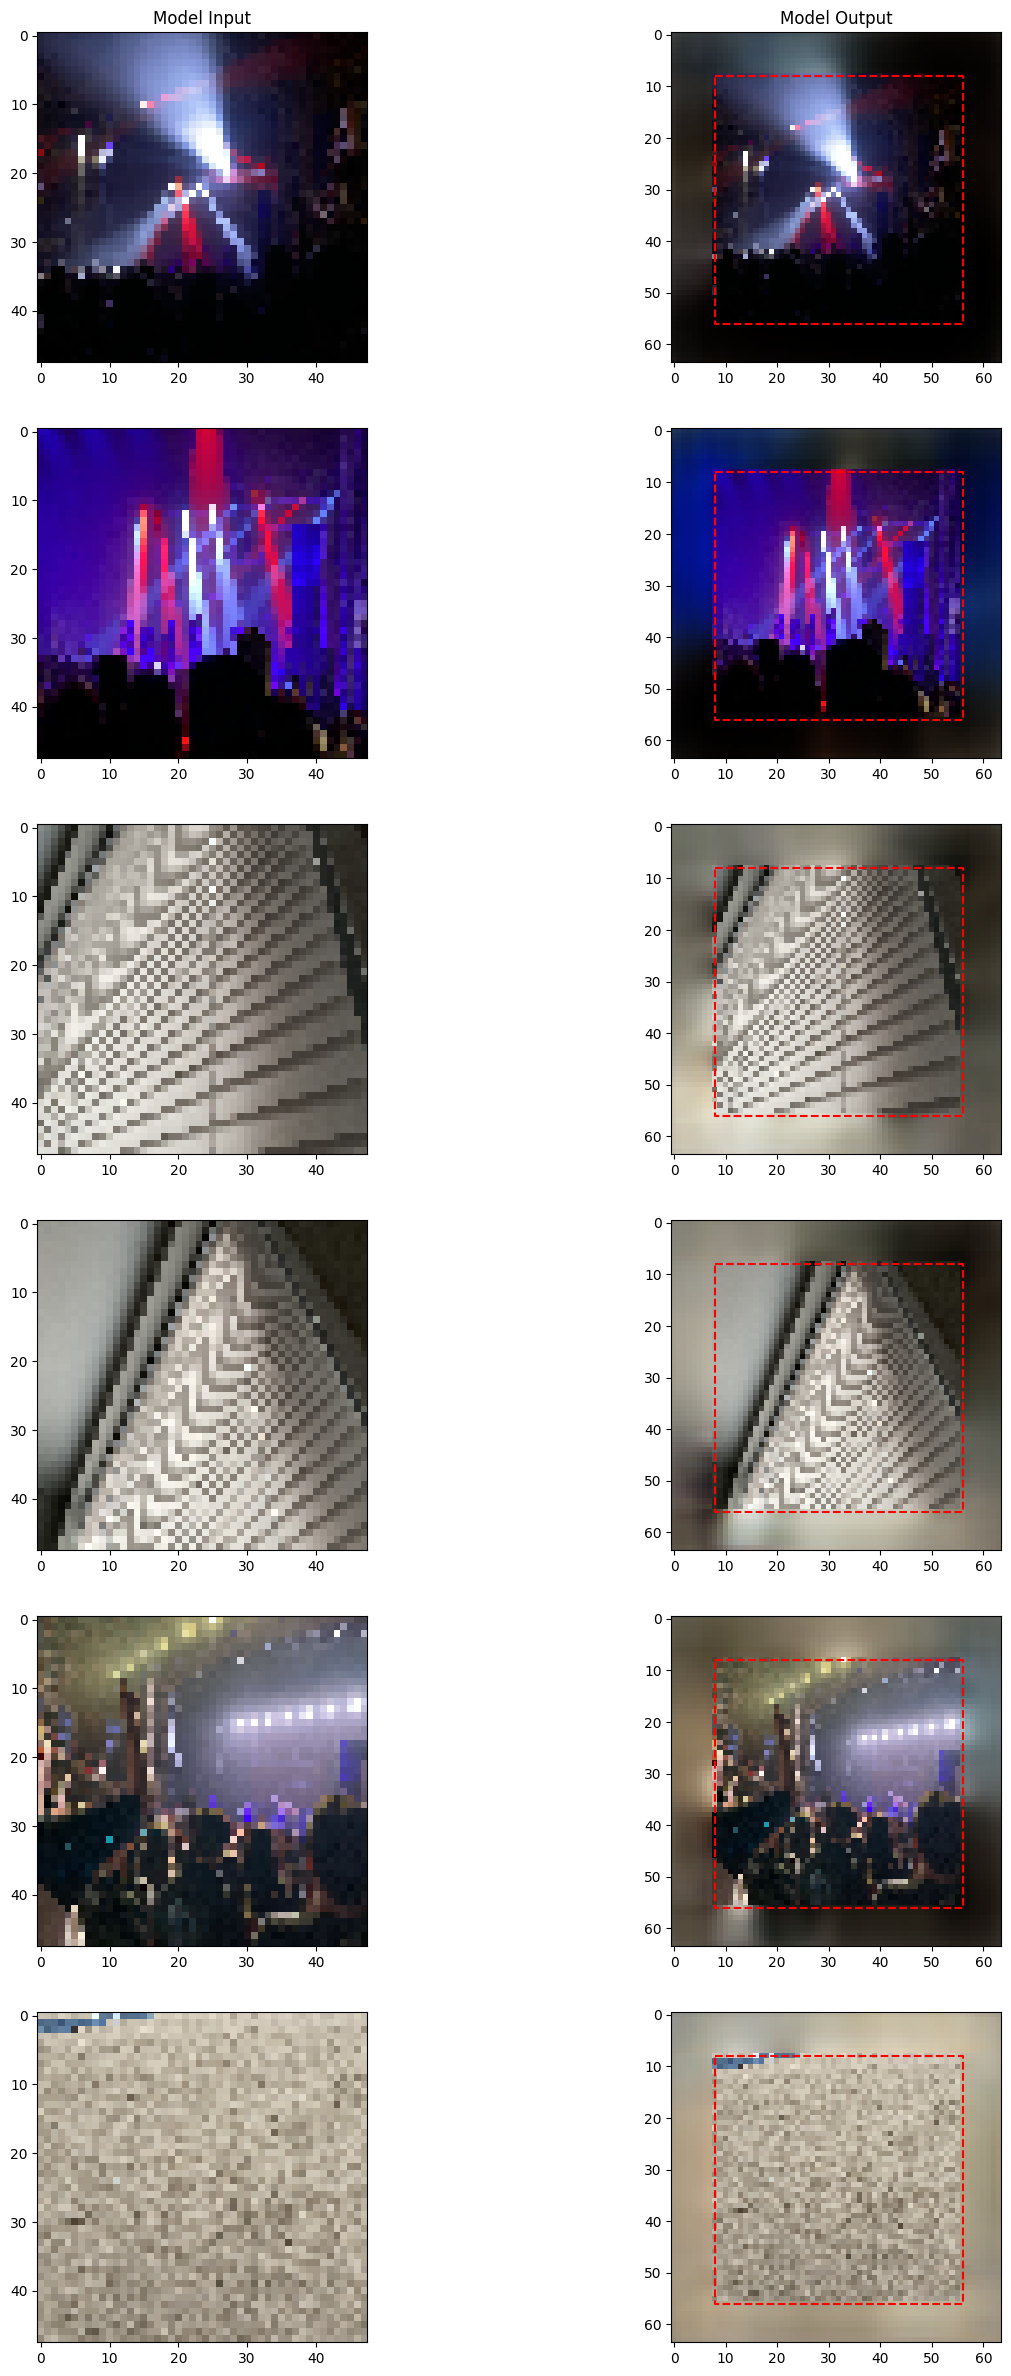

In [38]:
num_sample_image = len(images_list)

fig, axs = plt.subplots(num_sample_image, 2,figsize=(15,30))

# would this be faster to combine the images in a single batch?

for i,image_name in enumerate(images_list):
  image_path = directory_of_images_to_use + "/" + image_name

  image_heif = pillow_heif.open_heif(image_path)
  image_np_array = np.asarray(image_heif)

  image = tf.image.resize(image_heif,[SAMPLE_HEIGHT,SAMPLE_WIDTH])
  image = tf.cast(image,tf.float32) / 255.0

  image = tf.expand_dims(image,axis=0)
  print(image.shape)

  axs[i,0].imshow(image[0])

  if (i==0):
    axs[i,0].set_title("Model Input")

  predicted_image = reformat_image(model.predict(image))

  axs[i,1].imshow(predicted_image)

  if (i == 0):
    axs[i,1].set_title(f"Model Output")

  if (enable_overlay):
    plot_overlay(ax=axs[i,1])



#  image = tf.image.resize(image,[TOTAL_HEIGHT,TOTAL_WIDTH])

#  plt.imshow(image_np_array)

  # heif_file = pillow_heif.open_heif("file.heif")
  # np_array = np.asarray(heif_file)

  # heif_file = pillow_heif.open_heif("file.heif")
  # np_array = np.asarray(heif_file[0])     # accessing image by index.

#  new_image = image.

#  tensored_image = tf.image.decode_image(image,channels=3)

#  print(image.shape)


# Displaying Filters from the Layers


(3, 3, 3, 64)
conv2d_11 : <class 'keras.layers.convolutional.conv2d.Conv2D'>
Num Filters = 64


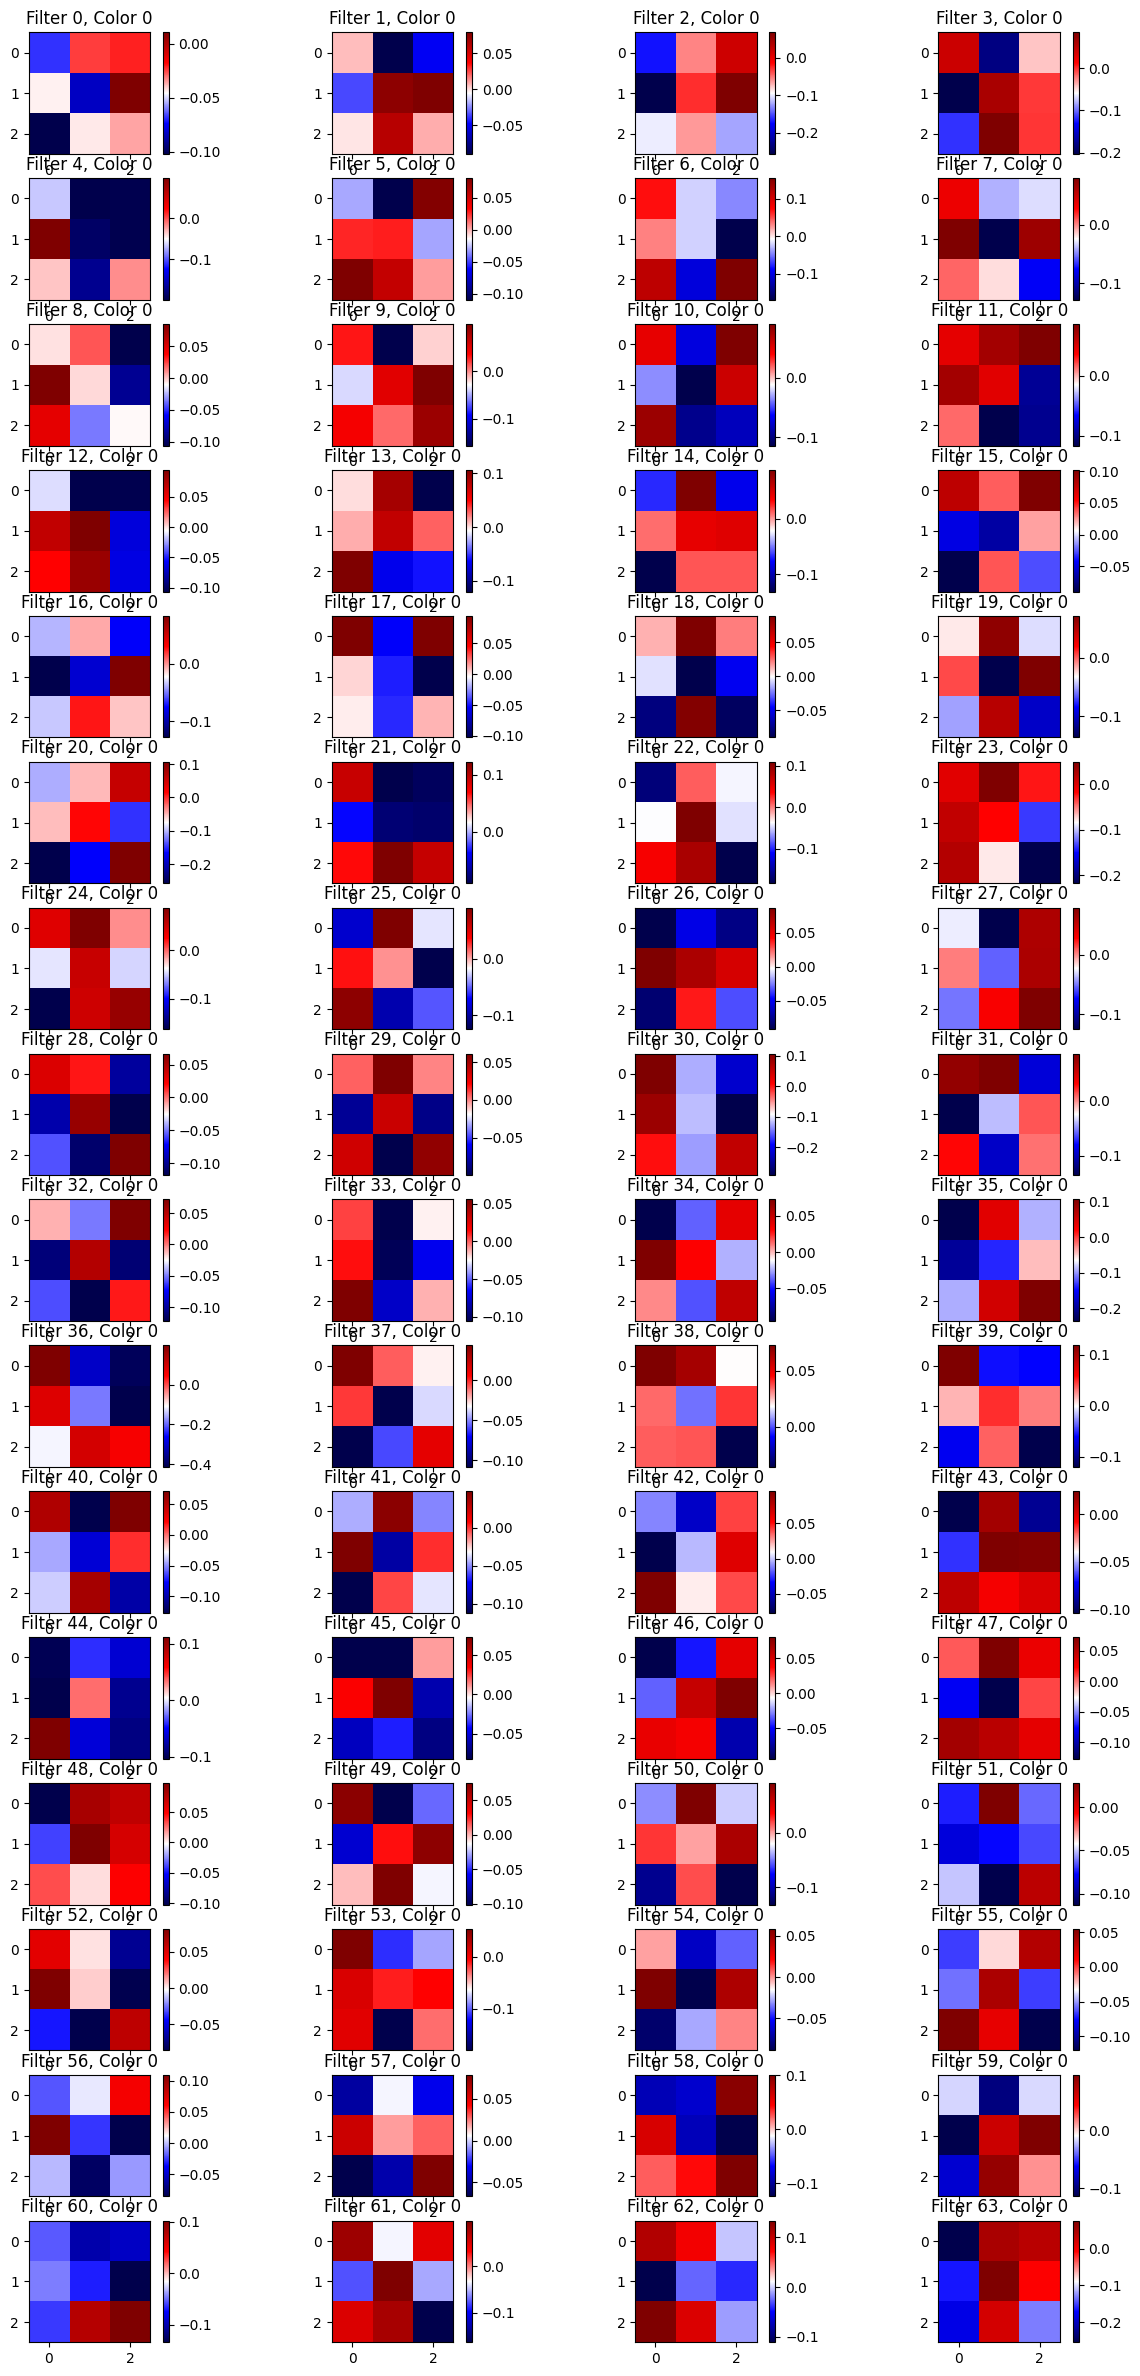

(7, 7, 64, 128)
conv2d_12 : <class 'keras.layers.convolutional.conv2d.Conv2D'>
Num Filters = 128


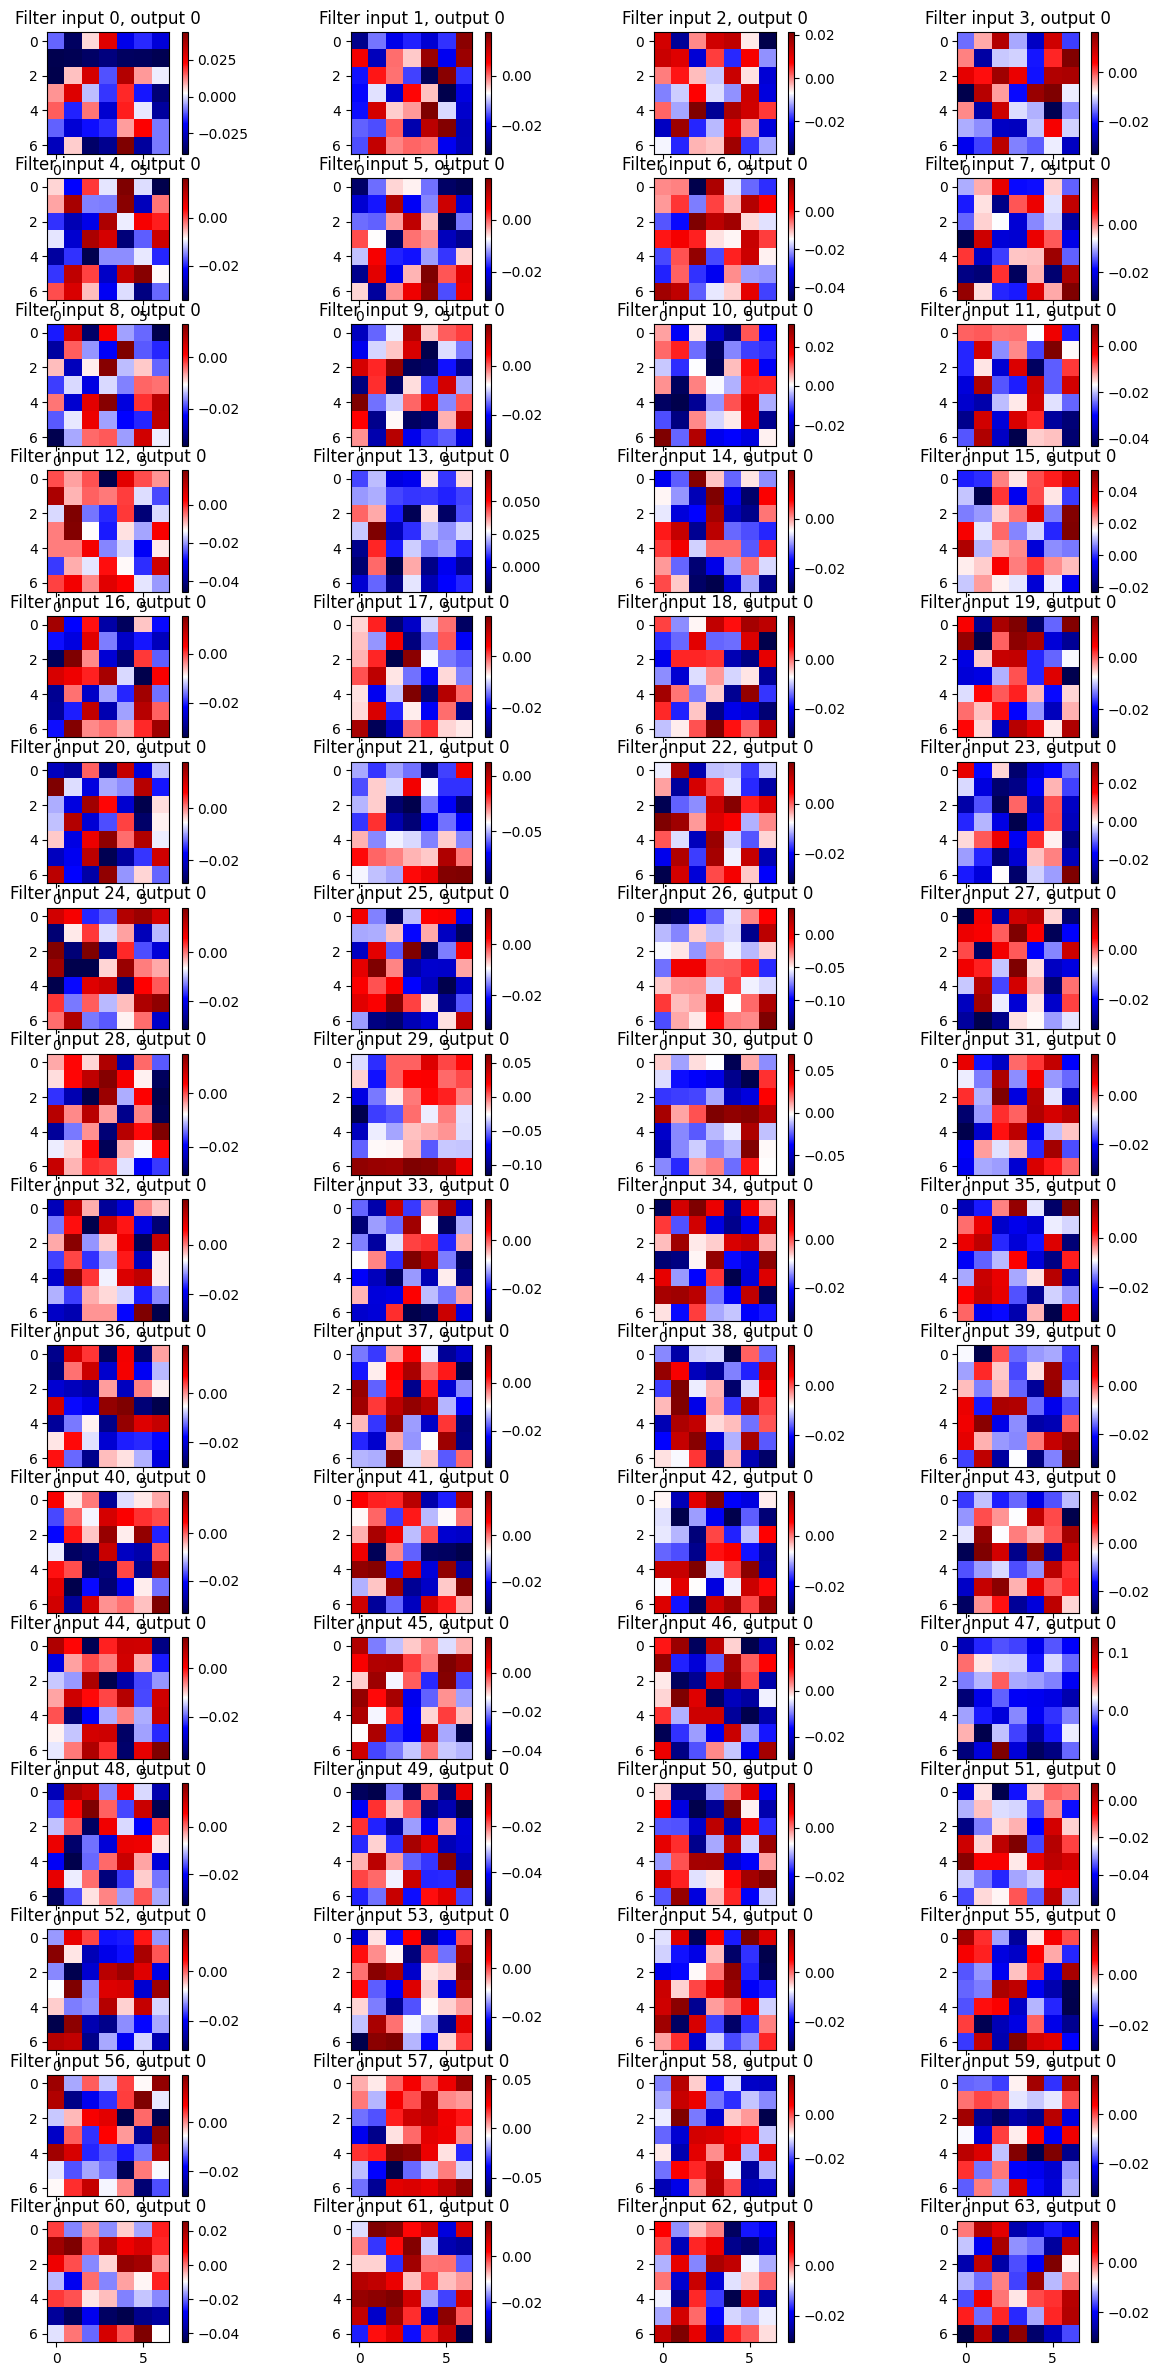

(13, 13, 128, 128)
conv2d_13 : <class 'keras.layers.convolutional.conv2d.Conv2D'>
Num Filters = 128


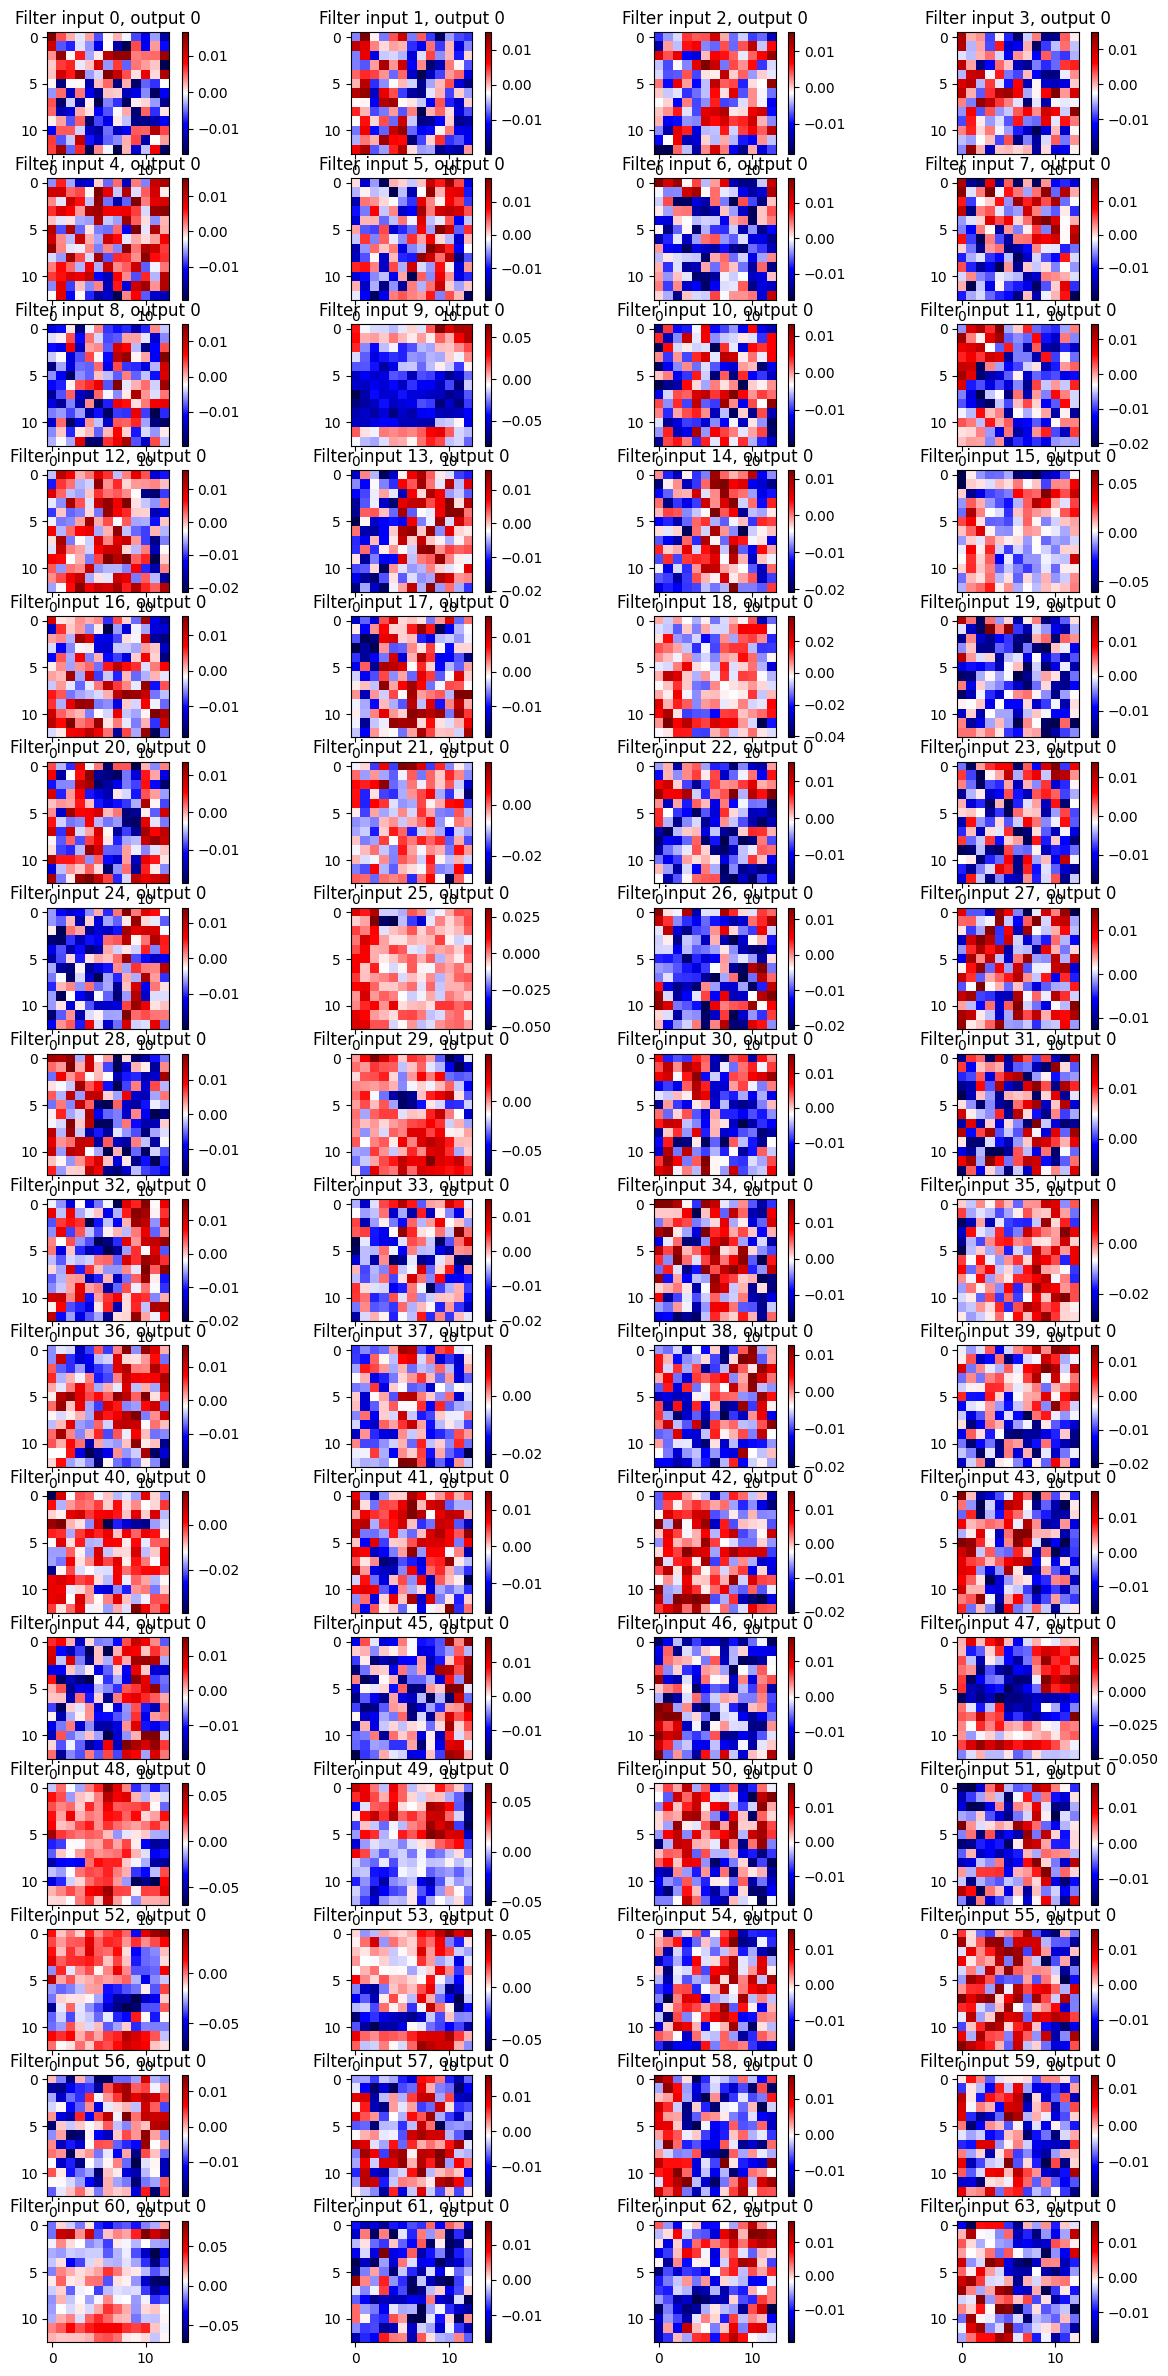

(13, 13, 128, 128)
conv2d_14 : <class 'keras.layers.convolutional.conv2d.Conv2D'>
Num Filters = 128


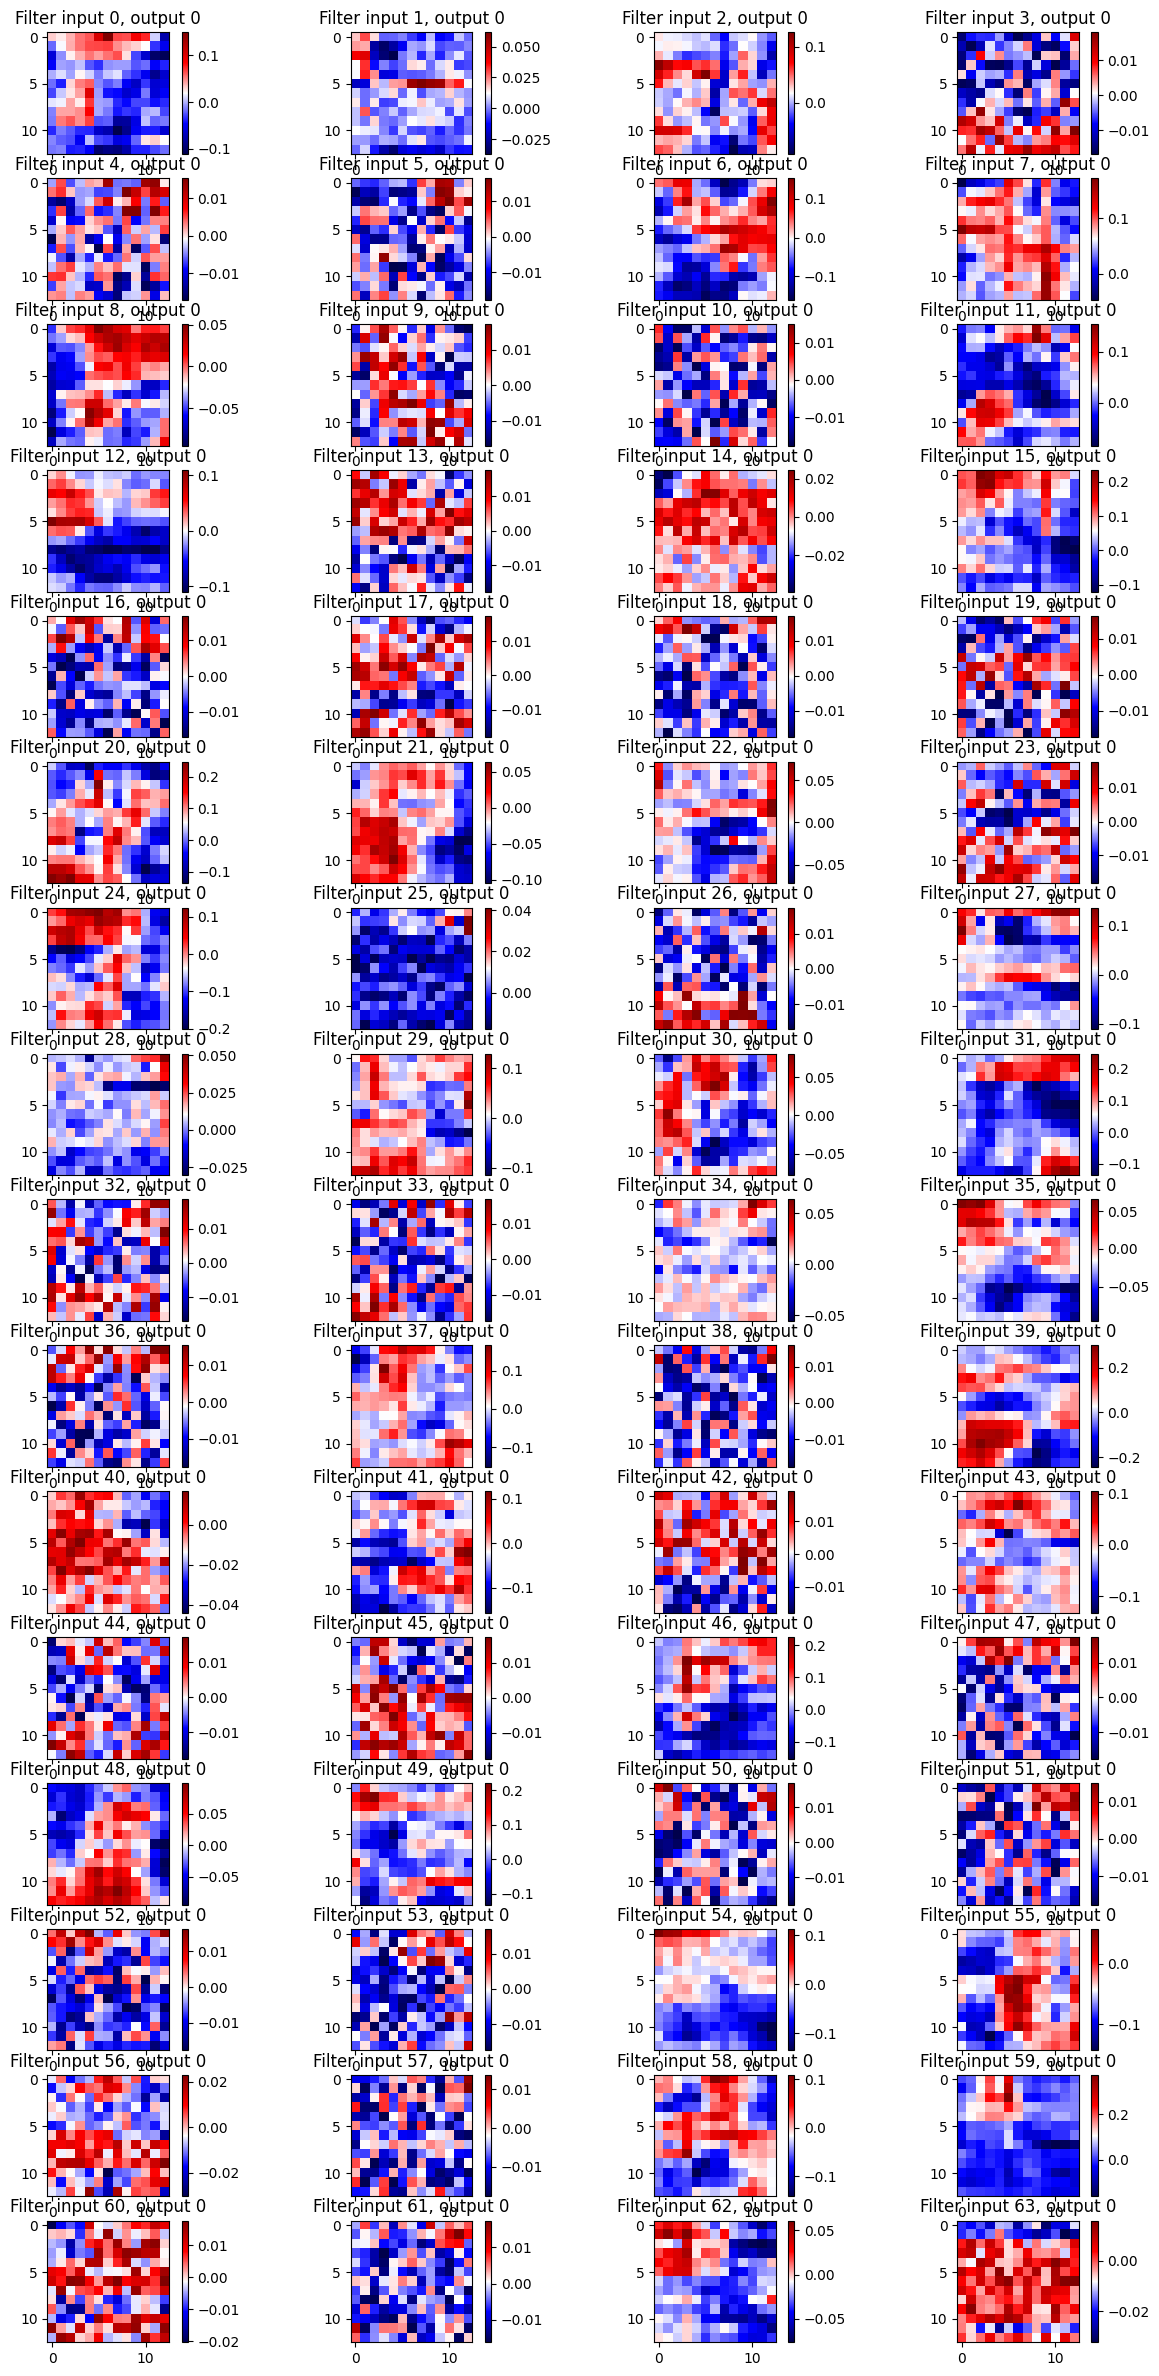

(13, 13, 3, 128)
conv2d_transpose_3 : <class 'keras.layers.convolutional.conv2d_transpose.Conv2DTranspose'>
Num Filters = 128


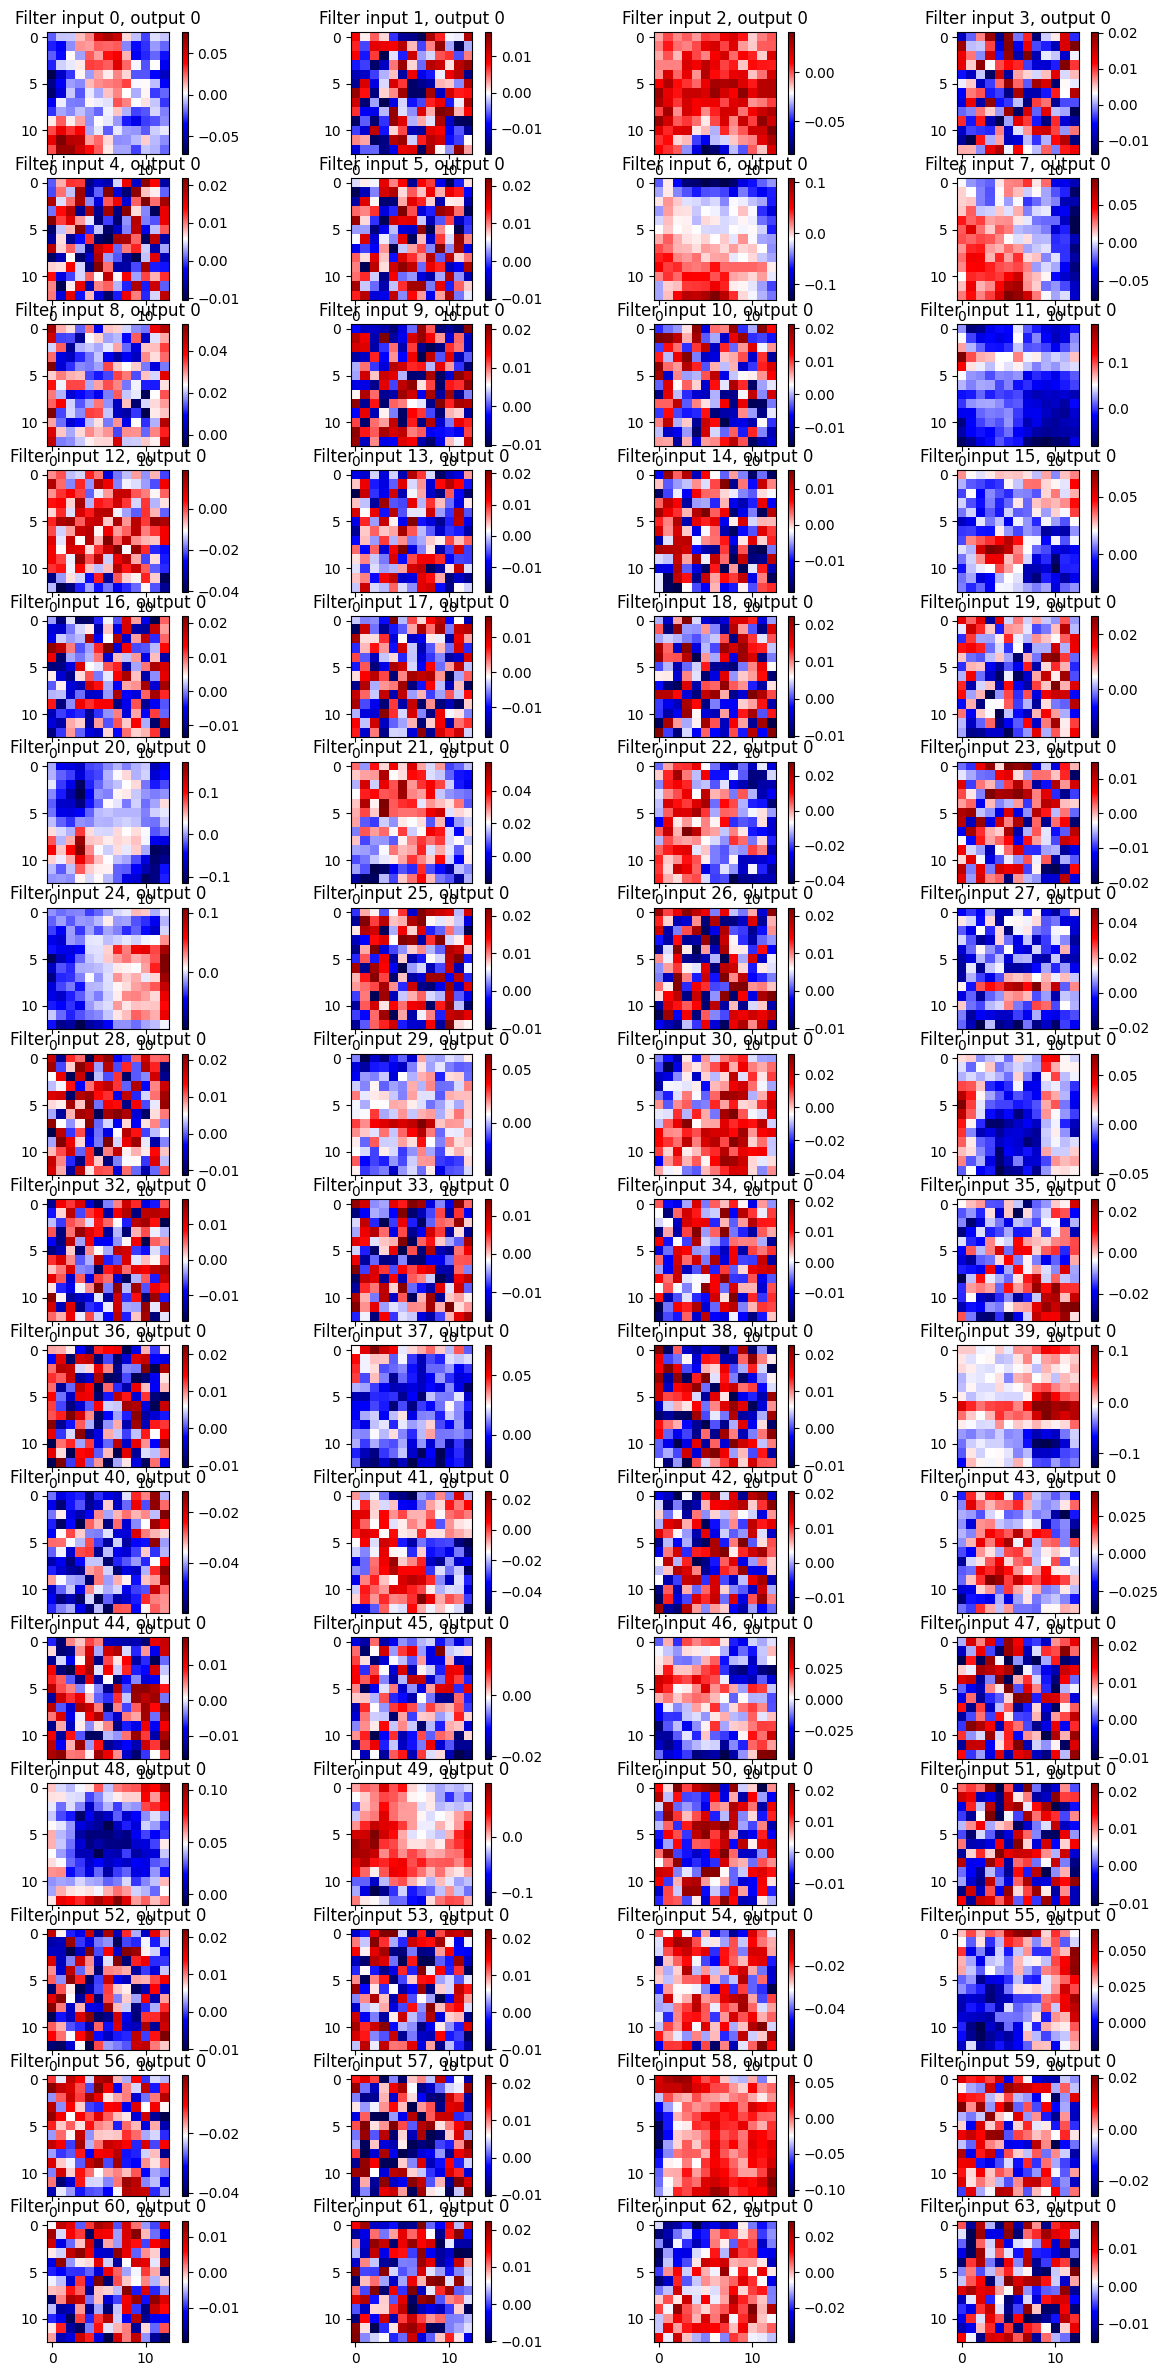

In [39]:
# Display some of the filters within the CNN

# model

num_conv_layers = 0


for layer in model.layers:

  if 'conv' not in layer.name:
    continue

  filters, biases = layer.get_weights()
  print(filters.shape)

  # does this AI gen code work?
  # normalize filter values to 0-1 so we can visualize them
  f_min, f_max = filters.min(), filters.max()

  print(f"{layer.name} : {type(layer)}")
  num_filters = filters.shape[3]
  print(f"Num Filters = {num_filters}")


  num_cols = 4
  num_rows = 16
  fig, axs = plt.subplots(num_rows, num_cols , figsize=(15,30))


  for i in range(num_filters):
    if i >= num_cols*num_rows:
      break

    color_index = 0
    filter_indiv = filters[:,:,color_index,i]
    local_row = i // num_cols
    local_col = i % num_cols

#    axs[local_row,local_col].imshow(filter_indiv,cmap='gray')
    img = axs[local_row,local_col].imshow(filter_indiv,cmap='seismic')
    if num_conv_layers == 0:
      axs[local_row,local_col].set_title(f"Filter {i}, Color {color_index}")
    else:
      axs[local_row,local_col].set_title(f"Filter input {i}, output {color_index}")

    plt.colorbar(img)
  plt.show()
  num_conv_layers += 1



If my understanding is correct, the assignment of color based on the 3rd index is only correct for the first and last layers. The first layer has the 3 colors by necessity: that is how all 2D conv layers on RGB images work. The final layer has 3 colors because I forced it to have 3 filters in order to have the right output shape, assigning the filters to a color output based on their position.

